In [1]:
!pip install category_encoders
!pip install scipy
!pip install statsmodels


In [2]:
import pandas as pd

# Импортируем объект Counter из модуля collections
from collections import Counter
import re
import numpy as np
from sklearn import preprocessing
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
import os.path


# Для стат тестов импортируем библиотеки и сразу присвоим уровень значимости
import scipy.stats as stats
alpha=0.05


# Загрузка Данных

In [3]:
if os.path.exists('/kaggle/input/sf-booking/hotels_train.csv')==False:
    from google.colab import drive
    drive.mount('/content/drive')

Т.к. Kaggle плохо подсказывает блокнот делался на GoogleCollab

In [4]:
if os.path.exists('/content/hotels.csv'):
    hotels = pd.read_csv('/content/hotels.csv')

elif os.path.exists('//content/drive/MyDrive/Colab Notebooks/SkilFactory/Блок 3. Разведывательный анализ данных/Проект/hotels.csv'):
    hotels = pd.read_csv('//content/drive/MyDrive/Colab Notebooks/SkilFactory/Блок 3. Разведывательный анализ данных/Проект/hotels.csv')

elif os.path.exists('/kaggle/input/sf-booking/hotels_train.csv'):
    hotels = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')
    
    
    
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


## Проведём беглый осмотр таблиц

In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
# Создадим словарь список с названиями колонок
listStartCollNames=hotels.columns
listStartCollNames

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [7]:
hotels.describe(include=[object])

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


In [8]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [9]:
# Найдём столбцы с пропущенными значениями

hotels.isnull().sum()[hotels.isnull().sum()>0]

lat    2448
lng    2448
dtype: int64

# 2. Разведывательный анализ данных

# Работа с числовыми признаками

In [10]:
# Выделим числовые признаки в отдельный список
List_intCollumns=hotels.select_dtypes(['int64', 'float64']).columns
List_intCollumns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat',
       'lng'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='review_total_negative_word_counts', ylabel='reviewer_score'>

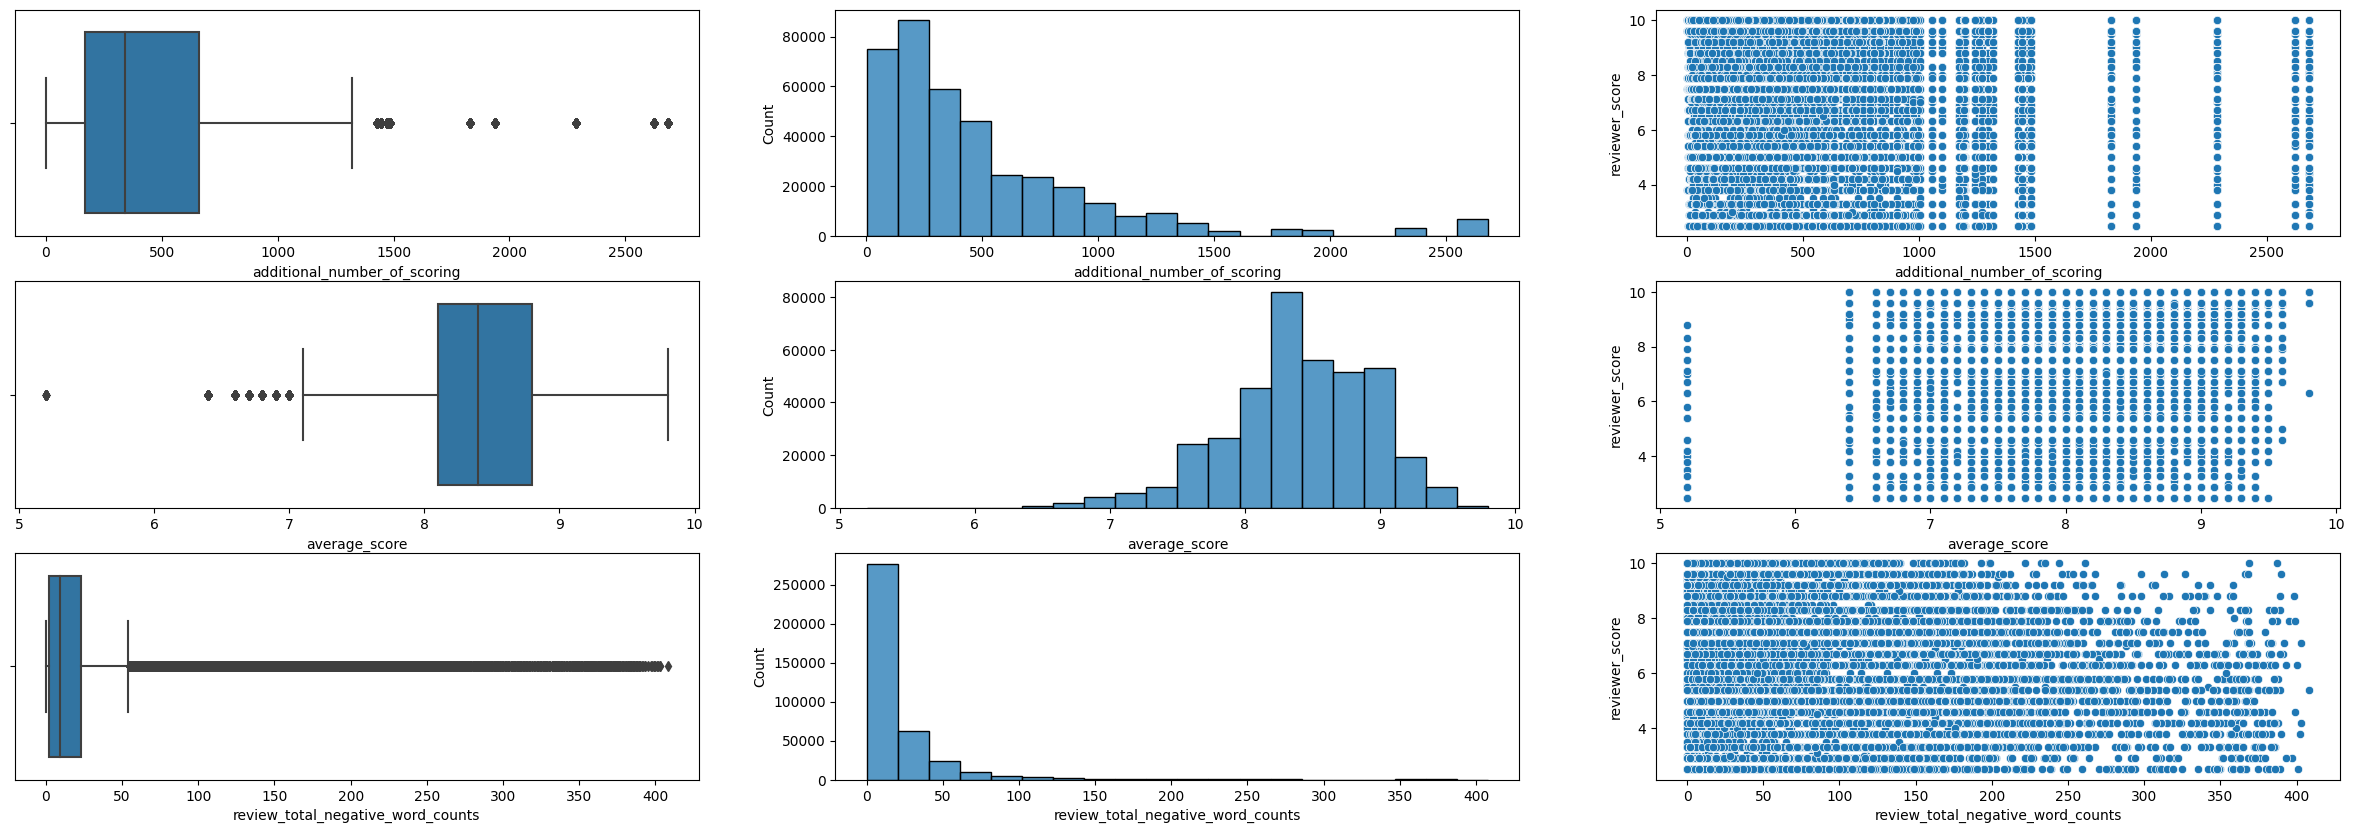

In [11]:
# Нарисуем для каждого Числового признака коробку Тьюкки и Гистограмму и Граффик зависимости целевого признака от текущего

fig,axes=plt.subplots(nrows=3,ncols=3,figsize=(30,10))

sns.boxplot(x=hotels['additional_number_of_scoring'],ax=axes[(0,0)])
# axes[(0,0)].boxplot(x=hotels['additional_number_of_scoring'],vert=False)
sns.histplot(x=hotels['additional_number_of_scoring'],ax=axes[(0,1)],bins=20)
sns.scatterplot(x=hotels['additional_number_of_scoring'],y=hotels['reviewer_score'],ax=axes[(0,2)])

sns.boxplot(x=hotels['average_score'],ax=axes[(1,0)])
# axes[(1,0)].boxplot(x=hotels['average_score'],vert=False)
sns.histplot(x=hotels['average_score'],ax=axes[(1,1)],bins=20)
sns.scatterplot(x=hotels['average_score'],y=hotels['reviewer_score'],ax=axes[(1,2)])

sns.boxplot(x=hotels['review_total_negative_word_counts'],ax=axes[(2,0)])
# axes[(2,0)].boxplot(x=hotels['review_total_negative_word_counts'],vert=False)
sns.histplot(x=hotels['review_total_negative_word_counts'],ax=axes[(2,1)],bins=20)
sns.scatterplot(x=hotels['review_total_negative_word_counts'],y=hotels['reviewer_score'],ax=axes[(2,2)])




/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='additional_number_of_scoring', ylabel='reviewer_score'>

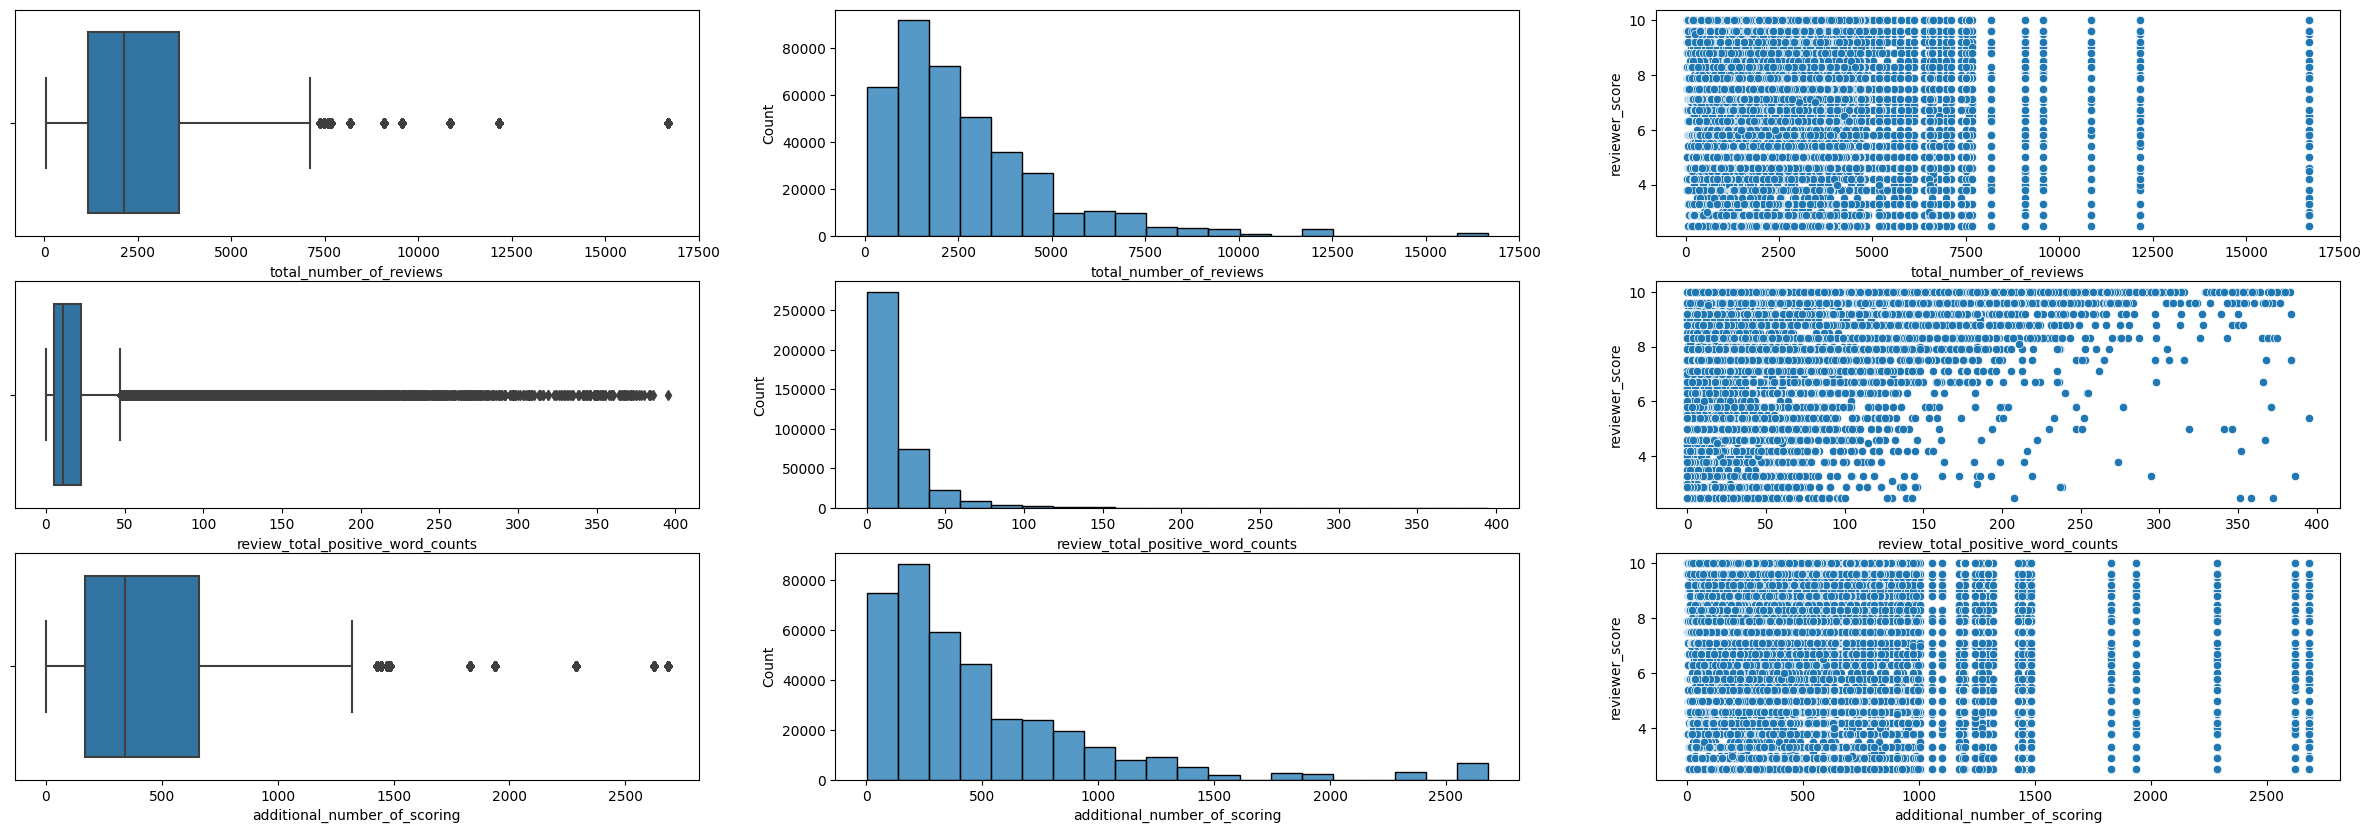

In [12]:
fig,axes=plt.subplots(nrows=3,ncols=3,figsize=(30,10))

sns.boxplot(x=hotels['total_number_of_reviews'],ax=axes[(0,0)])
#axes[(0,0)].boxplot(x=hotels['total_number_of_reviews'],vert=False)
sns.histplot(x=hotels['total_number_of_reviews'],ax=axes[(0,1)],bins=20)
sns.scatterplot(x=hotels['total_number_of_reviews'],y=hotels['reviewer_score'],ax=axes[(0,2)])

sns.boxplot(x=hotels['review_total_positive_word_counts'],ax=axes[(1,0)])
#axes[(1,0)].boxplot(x=hotels['review_total_positive_word_counts'],vert=False)
sns.histplot(x=hotels['review_total_positive_word_counts'],ax=axes[(1,1)],bins=20)
sns.scatterplot(x=hotels['review_total_positive_word_counts'],y=hotels['reviewer_score'],ax=axes[(1,2)])

sns.boxplot(x=hotels['additional_number_of_scoring'],ax=axes[(2,0)])
#axes[(2,0)].boxplot(x=hotels['additional_number_of_scoring'],vert=False)
sns.histplot(x=hotels['additional_number_of_scoring'],ax=axes[(2,1)],bins=20)
sns.scatterplot(x=hotels['additional_number_of_scoring'],y=hotels['reviewer_score'],ax=axes[(2,2)])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lng', ylabel='reviewer_score'>

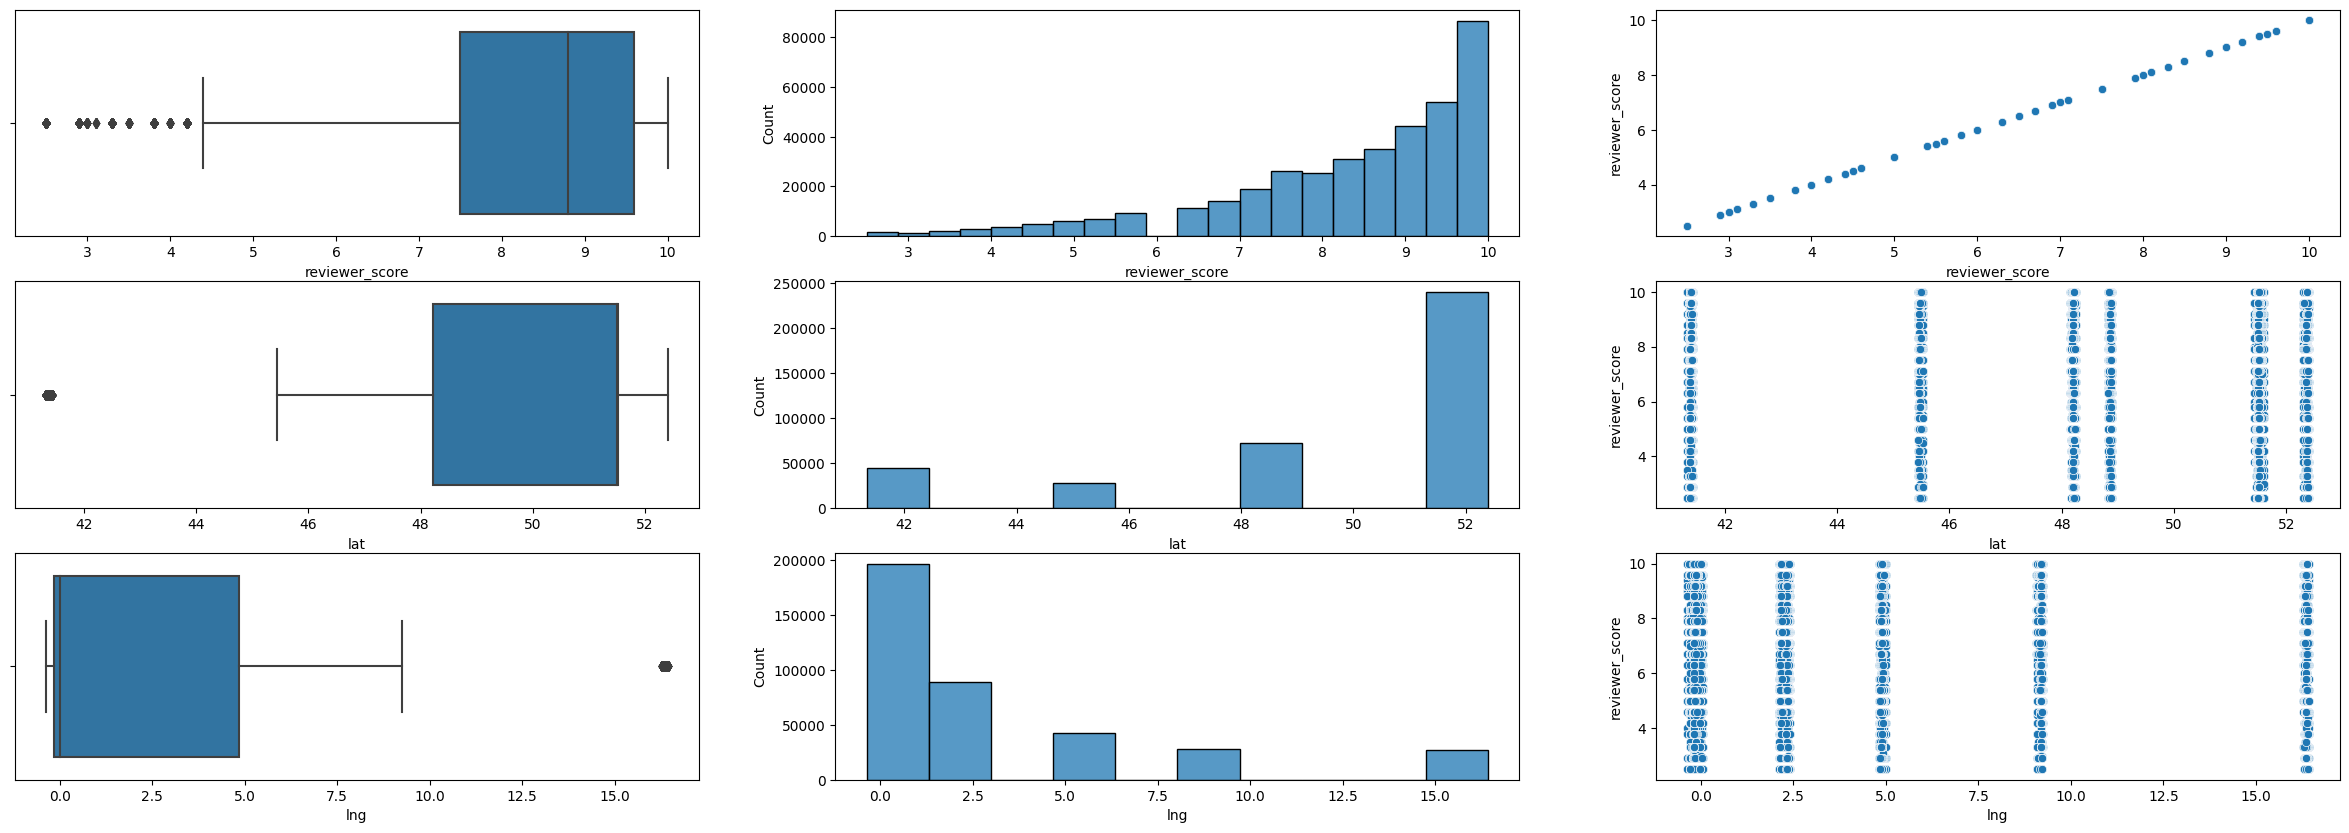

In [13]:
fig,axes=plt.subplots(nrows=3,ncols=3,figsize=(30,10))

sns.boxplot(x=hotels['reviewer_score'],ax=axes[(0,0)])
#axes[(0,0)].boxplot(x=hotels['reviewer_score'],vert=False)
sns.histplot(x=hotels['reviewer_score'],ax=axes[(0,1)],bins=20)
sns.scatterplot(x=hotels['reviewer_score'],y=hotels['reviewer_score'],ax=axes[(0,2)])

sns.boxplot(x=hotels['lat'],ax=axes[(1,0)])
#axes[(1,0)].boxplot(x=hotels['lat'],vert=False)
sns.histplot(x=hotels['lat'],ax=axes[(1,1)],bins=10)
sns.scatterplot(x=hotels['lat'],y=hotels['reviewer_score'],ax=axes[(1,2)])

sns.boxplot(x=hotels['lng'],ax=axes[(2,0)])
#axes[(2,0)].boxplot(x=hotels['lng'],vert=False)
sns.histplot(x=hotels['lng'],ax=axes[(2,1)],bins=10)
sns.scatterplot(x=hotels['lng'],y=hotels['reviewer_score'],ax=axes[(2,2)])

На  граффиках scatterplot  ничего не понятно . Кроме одного  review_total_positive_word_counts   там видно что  есть  некая линейная связь

In [14]:
# Удалим из спаиска  Числовых признаков целевой и  будем избовлятся от выбросов и

List_intCollumns=list(List_intCollumns)
List_intCollumns.remove("reviewer_score")

# Также удалим координаты отелей - там есть пропуски их можно заполнить
List_intCollumns.remove('lat')
List_intCollumns.remove('lng')



In [15]:
# Проверим признаки на нормальность
# К нормальным применим известные методы очистки выбросов
List_NormalColl=[]
List_NotNormalColl=[]

for strCollName in List_intCollumns:


    seriesTestColl=hotels[strCollName]

    # Проведём тест Шапиро_Уика

    _,p=stats.shapiro(seriesTestColl)


    # Если признак распределён не нормально  то возьмём натуральный логарифм и попробуем снова тест Шапиро_Уика
    if p<=alpha:
      seriesTestColl=np.log(seriesTestColl+1)
      _,p=stats.shapiro(seriesTestColl)
    else:
      print(f"{strCollName} прологорифмируем и снова попробуем")

    if p<=alpha:
      print(f"{strCollName} - распределён не нормальное")
      List_NotNormalColl.append(strCollName)
    else:
      print(f"{strCollName} - распределён нормально")
      List_NormalColl.append(strCollName)


List_NormalColl

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)


additional_number_of_scoring - распределён не нормальное
average_score - распределён не нормальное
review_total_negative_word_counts - распределён не нормальное
total_number_of_reviews - распределён не нормальное
review_total_positive_word_counts - распределён не нормальное
total_number_of_reviews_reviewer_has_given - распределён не нормальное


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)


[]

Все признаки распределены не нормально - Даже не похоже


In [16]:
# напишем функцию котрая будет приравнивать выброс к 3ей или 1ой квантили И будет собирать массив индексов строк с выбросами

# Множество строк которые нужно удалить
set_Row_ForDell=set()

def quant_1_or_3(hotels:pd.DataFrame, CollName:str):

      SeriesColl=hotels[CollName].copy()
      quartile_1= SeriesColl.quantile(0.25)
      quartile_3 =SeriesColl.quantile(0.75)
      iqr = quartile_3 - quartile_1

      index_Min_1=(SeriesColl[SeriesColl<(quartile_1  - (1.5*iqr))   ]).index
      SeriesColl.loc[index_Min_1]=SeriesColl.quantile(0.25)
      print(f"Для {CollName} первая квантиль равна {SeriesColl.quantile(0.25)}")



      index_Max_3=(SeriesColl[SeriesColl>(quartile_3  + (1.5*iqr))   ]).index
      SeriesColl.loc[index_Max_3]=SeriesColl.quantile(0.75)
      print(f"Для {CollName} третья квантиль равна {SeriesColl.quantile(0.75)}")

      print(f"Для признака {CollName} имеется {len(index_Min_1)+ len(index_Max_3)} выбросов")

      set_Row_ForDell=set(index_Min_1)|set(index_Max_3)

      return SeriesColl,set_Row_ForDell


for CollName in List_intCollumns:
    hotels[CollName+"_Test"]=quant_1_or_3(hotels,CollName)[0]
    set_Row_ForDell=set_Row_ForDell|quant_1_or_3(hotels,CollName)[1]



Для additional_number_of_scoring первая квантиль равна 169.0
Для additional_number_of_scoring третья квантиль равна 660.0
Для признака additional_number_of_scoring имеется 22160 выбросов
Для additional_number_of_scoring первая квантиль равна 169.0
Для additional_number_of_scoring третья квантиль равна 660.0
Для признака additional_number_of_scoring имеется 22160 выбросов
Для average_score первая квантиль равна 8.1
Для average_score третья квантиль равна 8.8
Для признака average_score имеется 7145 выбросов
Для average_score первая квантиль равна 8.1
Для average_score третья квантиль равна 8.8
Для признака average_score имеется 7145 выбросов
Для review_total_negative_word_counts первая квантиль равна 2.0
Для review_total_negative_word_counts третья квантиль равна 23.0
Для признака review_total_negative_word_counts имеется 29326 выбросов
Для review_total_negative_word_counts первая квантиль равна 2.0
Для review_total_negative_word_counts третья квантиль равна 23.0
Для признака review_tota

## Проверим как теперь выгледят признаки с самым большим количеством выбросов
<!-- Если они корректные  значит и у остольных всё хорошо -->

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='review_total_positive_word_counts_Test', ylabel='reviewer_score'>

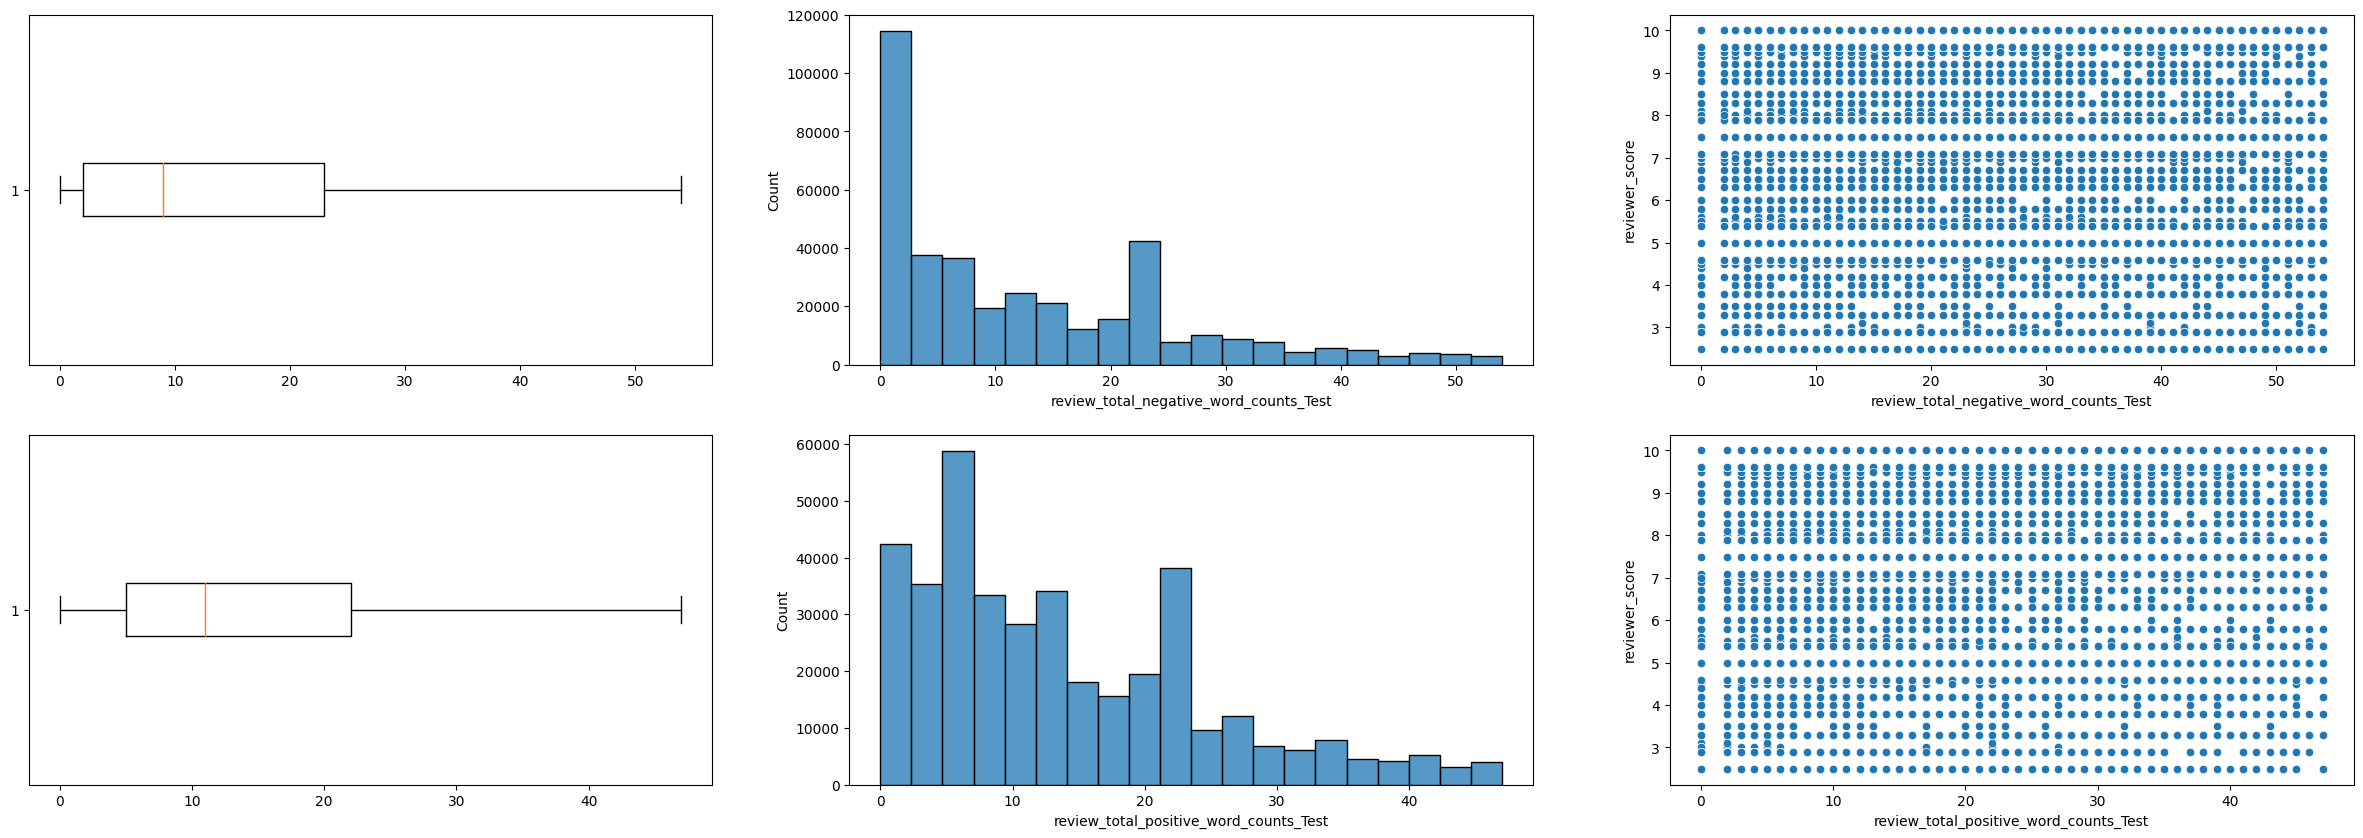

In [17]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(30,10))

# sns.boxplot(x=hotels['total_number_of_reviews'],ax=axes[(0,0)])
axes[(0,0)].boxplot(x=hotels['review_total_negative_word_counts_Test'],vert=False)
sns.histplot(x=hotels['review_total_negative_word_counts_Test'],ax=axes[(0,1)],bins=20)
sns.scatterplot(x=hotels['review_total_negative_word_counts_Test'],y=hotels['reviewer_score'],ax=axes[(0,2)])

# sns.boxplot(x=hotels['review_total_positive_word_counts'],ax=axes[(1,0)])
axes[(1,0)].boxplot(x=hotels['review_total_positive_word_counts_Test'],vert=False)
sns.histplot(x=hotels['review_total_positive_word_counts_Test'],ax=axes[(1,1)],bins=20)
sns.scatterplot(x=hotels['review_total_positive_word_counts_Test'],y=hotels['reviewer_score'],ax=axes[(1,2)])

Идея была неудачная. Нужно удалять выбросы. Результат модели сильно упал .

In [18]:
# Удалим строки с выбросами

hotels.drop(list(set_Row_ForDell),axis=0,inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='review_total_positive_word_counts', ylabel='reviewer_score'>

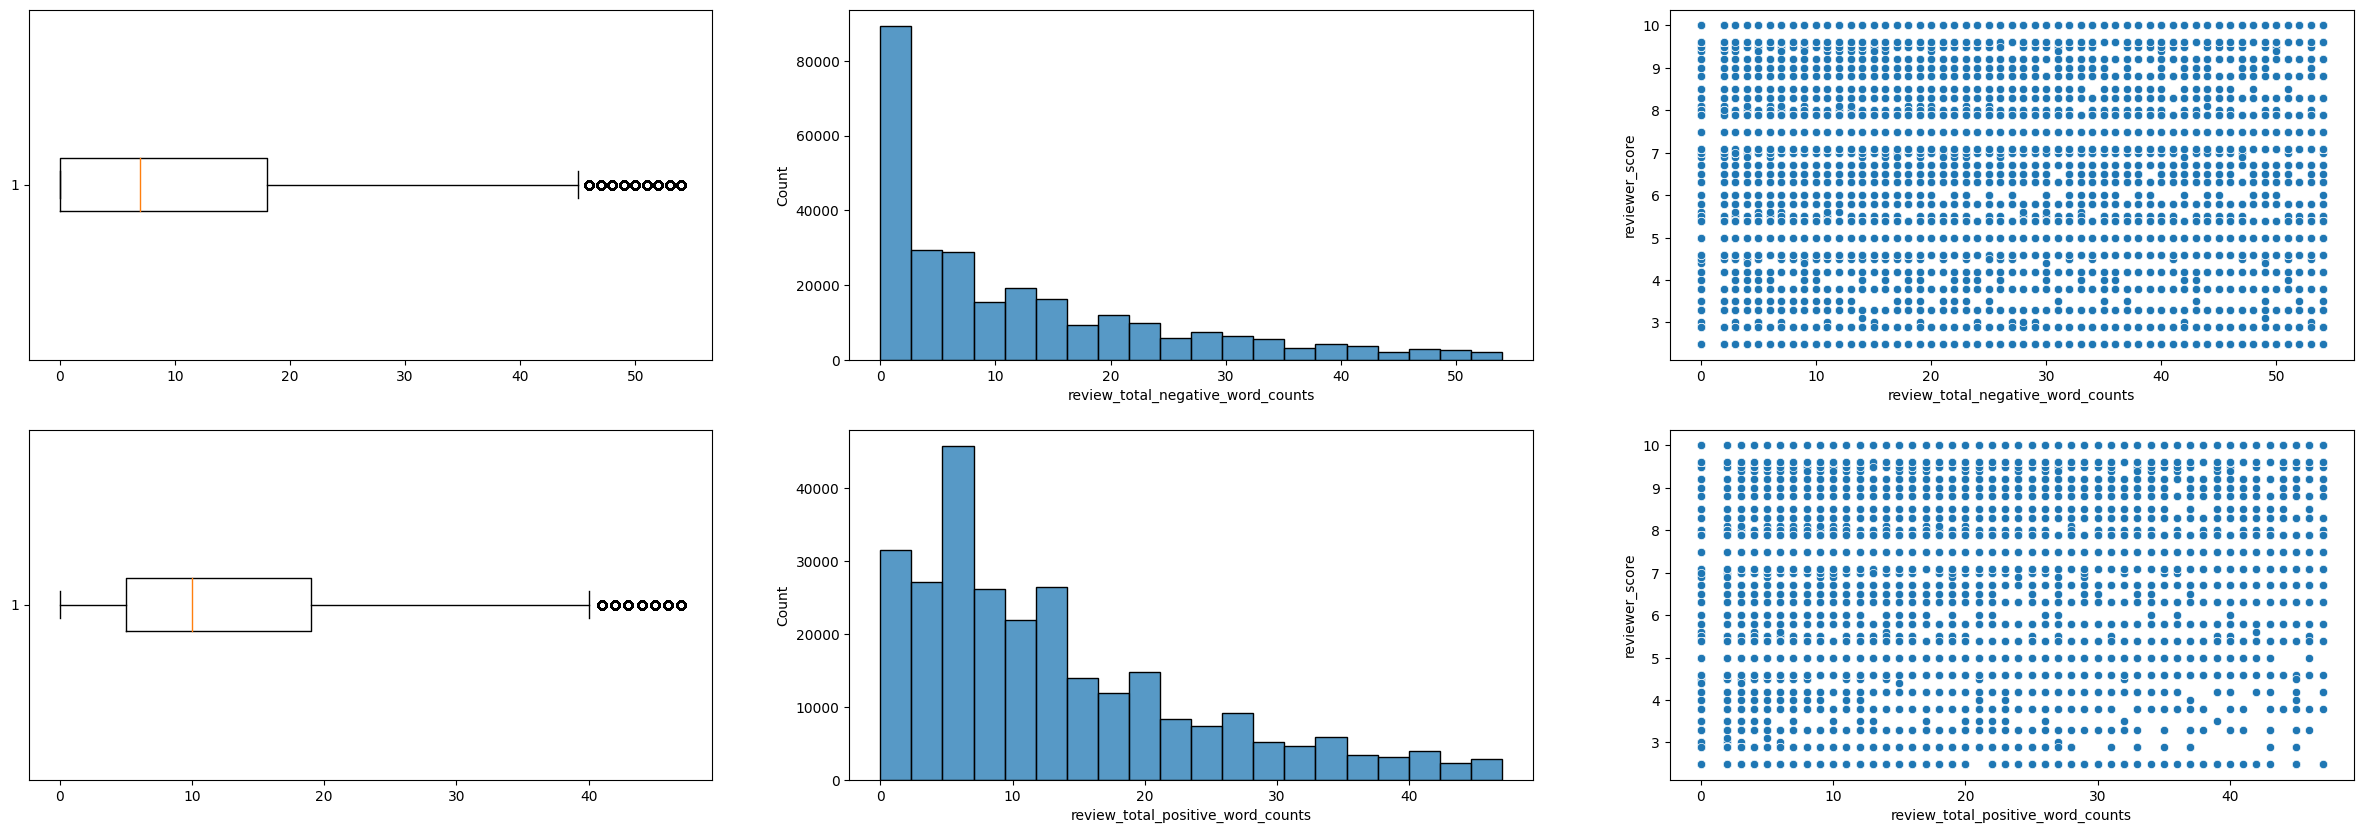

In [19]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(30,10))

# sns.boxplot(x=hotels['total_number_of_reviews'],ax=axes[(0,0)])
axes[(0,0)].boxplot(x=hotels['review_total_negative_word_counts'],vert=False)
sns.histplot(x=hotels['review_total_negative_word_counts'],ax=axes[(0,1)],bins=20)
sns.scatterplot(x=hotels['review_total_negative_word_counts'],y=hotels['reviewer_score'],ax=axes[(0,2)])

# sns.boxplot(x=hotels['review_total_positive_word_counts'],ax=axes[(1,0)])
axes[(1,0)].boxplot(x=hotels['review_total_positive_word_counts'],vert=False)
sns.histplot(x=hotels['review_total_positive_word_counts'],ax=axes[(1,1)],bins=20)
sns.scatterplot(x=hotels['review_total_positive_word_counts'],y=hotels['reviewer_score'],ax=axes[(1,2)])

In [20]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274891 entries, 0 to 386802
Data columns (total 23 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   hotel_address                                    274891 non-null  object 
 1   additional_number_of_scoring                     274891 non-null  int64  
 2   review_date                                      274891 non-null  object 
 3   average_score                                    274891 non-null  float64
 4   hotel_name                                       274891 non-null  object 
 5   reviewer_nationality                             274891 non-null  object 
 6   negative_review                                  274891 non-null  object 
 7   review_total_negative_word_counts                274891 non-null  int64  
 8   total_number_of_reviews                          274891 non-null  int64  
 9   positive_review     

Потеряли 111912  осталось 274891

In [21]:
# Удалим тестовые Столбцы
for CollName in List_intCollumns:
    hotels.drop(CollName+"_Test",axis=1,inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='review_total_positive_word_counts', ylabel='reviewer_score'>

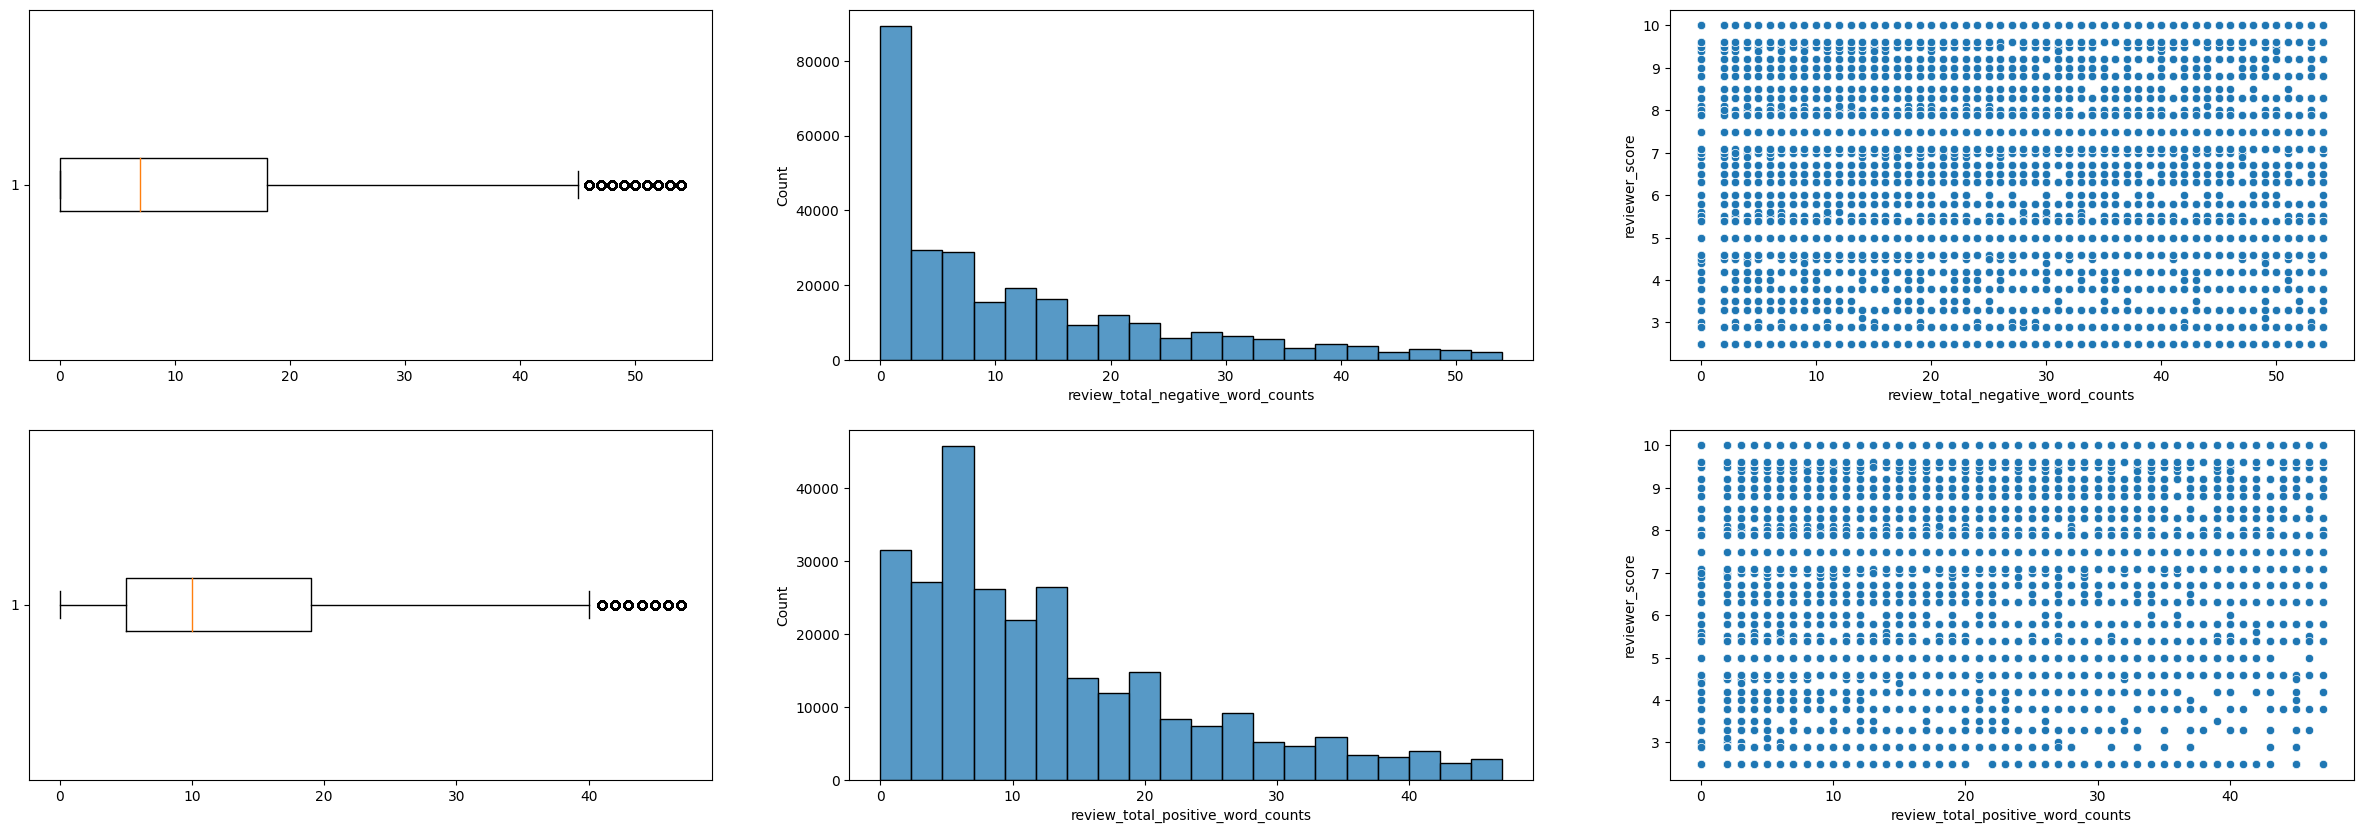

In [22]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(30,10))

# sns.boxplot(x=hotels['total_number_of_reviews'],ax=axes[(0,0)])
axes[(0,0)].boxplot(x=hotels['review_total_negative_word_counts'],vert=False)
sns.histplot(x=hotels['review_total_negative_word_counts'],ax=axes[(0,1)],bins=20)
sns.scatterplot(x=hotels['review_total_negative_word_counts'],y=hotels['reviewer_score'],ax=axes[(0,2)])

# sns.boxplot(x=hotels['review_total_positive_word_counts'],ax=axes[(1,0)])
axes[(1,0)].boxplot(x=hotels['review_total_positive_word_counts'],vert=False)
sns.histplot(x=hotels['review_total_positive_word_counts'],ax=axes[(1,1)],bins=20)
sns.scatterplot(x=hotels['review_total_positive_word_counts'],y=hotels['reviewer_score'],ax=axes[(1,2)])

In [23]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274891 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               274891 non-null  object 
 1   additional_number_of_scoring                274891 non-null  int64  
 2   review_date                                 274891 non-null  object 
 3   average_score                               274891 non-null  float64
 4   hotel_name                                  274891 non-null  object 
 5   reviewer_nationality                        274891 non-null  object 
 6   negative_review                             274891 non-null  object 
 7   review_total_negative_word_counts           274891 non-null  int64  
 8   total_number_of_reviews                     274891 non-null  int64  
 9   positive_review                             274891 non-null  object 
 10  r

# Соединим тестовый ДатаФрейм и Тренировачный

In [24]:
if os.path.exists('/kaggle/input/sf-booking/hotels_test.csv'):
    hotels_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv')
    hotels_test["TestFlag"]=1
    hotels["TestFlag"]=0
    
    hotels=pd.concat([hotels,hotels_test], ignore_index=True)


In [25]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403826 entries, 0 to 403825
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               403826 non-null  object 
 1   additional_number_of_scoring                403826 non-null  int64  
 2   review_date                                 403826 non-null  object 
 3   average_score                               403826 non-null  float64
 4   hotel_name                                  403826 non-null  object 
 5   reviewer_nationality                        403826 non-null  object 
 6   negative_review                             403826 non-null  object 
 7   review_total_negative_word_counts           403826 non-null  int64  
 8   total_number_of_reviews                     403826 non-null  int64  
 9   positive_review                             403826 non-null  object 
 

# Поработаем с каждым признаком отдельно

## Работа с датами

In [26]:
# Проверим пропуски
hotels['review_date'].isnull().sum()

0

In [27]:
# Преобразуем в datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])


In [28]:
hotels["review_date"].min()

hotels["review_date"].max()

print( f"самый свежий отзыв {hotels['review_date'].max()}   самый первый отзыв {hotels['review_date'].min()}" )

самый свежий отзыв 2017-08-03 00:00:00   самый первый отзыв 2015-08-04 00:00:00


# Поработаем с признаком tags — теги, которые рецензент дал отелю

In [29]:

# теги находятся внутри строки которая представляет собой список - нужно для кажного тега в таблице создать столбец с бинарным признаком
# 1 найдём все уникальные теги собрав их в коллекцию

# Создадим лист для коолекции
tags_set=set()

# Напишем функцию  которая превратит строку в список
# И добавит все теги во множество






def ConvertToList(test_string :str ,tags_set:set):
  # убираем лишние конструкции
  List_add=test_string.replace("'","").replace("[","").replace("]","").strip().split(" ,  ")
  # добавляем во  множество
  # global list_add_Tags
  # list_add_Tags=list_add_Tags+List_add
  tags_set.update(set(List_add))
  return  List_add




In [30]:
# Получаем котонку содержащую списки тегов



hotels["tags_list"]=hotels["tags"].apply(ConvertToList,tags_set=tags_set)

In [31]:
# Добавим колонку количества тегов
hotels["Tags_Count"]=hotels["tags_list"].apply(lambda x: len(x))

In [32]:
# Разобьём полученные списки тегов по одному
TagsHotelsDf=hotels["tags_list"].explode()
TagsHotelsDf =pd.DataFrame(TagsHotelsDf)
TagsHotelsDf["index_from_hotels"]=TagsHotelsDf.index


In [33]:
print(f"уникальных тегов представлено в наборе данных {len(tags_set)}")
# Если для каждого тега создать свою колонку Дана сет увеличится на на 2368 колонок

уникальных тегов представлено в наборе данных 2369


In [34]:
# Создадим таблицу справочник для обьединения с основной таблицей
modeTag=TagsHotelsDf["tags_list"].value_counts()[TagsHotelsDf["tags_list"].value_counts()==TagsHotelsDf["tags_list"].value_counts().sort_values(ascending=False).iloc[0]].index[0]
print(f"Наиболее часто встречающийся тег {modeTag}")


Наиболее часто встречающийся тег Leisure trip


## Достанем признак количества ночей и узнаем на сколько ночей чаще всего останавливаются

In [35]:
# Достанем признак количества ночей и узнаем на сколько ночей чаще всего останавливаются
NightCount=TagsHotelsDf["tags_list"].apply(lambda x : True if  re.fullmatch(r"[S,s]tayed \d{1,} [N,n]ights{0,1}", x) is not None else False)

In [36]:
modse_Count_Night=TagsHotelsDf[NightCount]["tags_list"].value_counts().sort_values(ascending=False).index[0]

In [37]:
modse_Count_Night_int=re.search(r"\d{1,}",modse_Count_Night)[0]
modse_Count_Night_int

'1'

In [38]:

print(f"Чаще всего останавливаются путешественники в отелях на {modse_Count_Night_int} ночь(ночей)")

Чаще всего останавливаются путешественники в отелях на 1 ночь(ночей)



## оставим только те теги котрые встречаются в 0,5% строк

In [39]:
TagsHotelsDf_value_count=TagsHotelsDf["tags_list"].value_counts()

In [40]:
# Добавим в таблицу отелей признак номера строки

hotels["index_from_hotels"]=hotels.index

In [41]:
TagsHotelsDf_value_count[TagsHotelsDf_value_count>hotels.shape[0]*0.05]

tags_list
Leisure trip                      329821
Submitted from a mobile device    249580
Couple                            199158
Stayed 1 night                    150841
Stayed 2 nights                   104650
Solo traveler                      81844
Stayed 3 nights                    75579
Business trip                      62191
Group                              51943
Family with young children         48264
Stayed 4 nights                    37794
Double Room                        26517
Superior Double Room               25208
Standard Double Room               24158
Family with older children         20966
Deluxe Double Room                 20594
Name: count, dtype: int64

In [42]:
# Соберём список теги которые встречаются в более чем в 5% строк

List_FamosTags=TagsHotelsDf_value_count[TagsHotelsDf_value_count>hotels.shape[0]*0.05].index
List_FamosTags


Index(['Leisure trip', 'Submitted from a mobile device', 'Couple',
       'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights',
       'Business trip', 'Group', 'Family with young children',
       'Stayed 4 nights', 'Double Room', 'Superior Double Room',
       'Standard Double Room', 'Family with older children',
       'Deluxe Double Room'],
      dtype='object', name='tags_list')

In [43]:
# теперь добавим эти теги в таблицу отелей  методом Merge

collName='Leisure trip'

for collName in List_FamosTags:

    TegTableForMerge=TagsHotelsDf[TagsHotelsDf["tags_list"]==collName].copy()

    TegTableForMerge.loc[:,"Tags_"+collName]=1

    TegTableForMerge.drop(["tags_list"],axis=1,inplace=True)


    hotels=hotels.merge(TegTableForMerge,how='left',left_on="index_from_hotels",right_on="index_from_hotels")

    hotels.fillna({"Tags_"+collName:0},inplace=True)

# Разберём признак даты более конкретно

In [44]:
# Достанем значение года из даты и добавим как отдельный признак

hotels["review_date_year"]=hotels["review_date"].dt.year

# получим из даты значение месяца и дня недели

hotels["review_date_day_of_week"]=hotels["review_date"].dt.strftime("%A")
hotels["review_date_month"]=hotels["review_date"].dt.strftime("%B")

<BarContainer object of 3 artists>

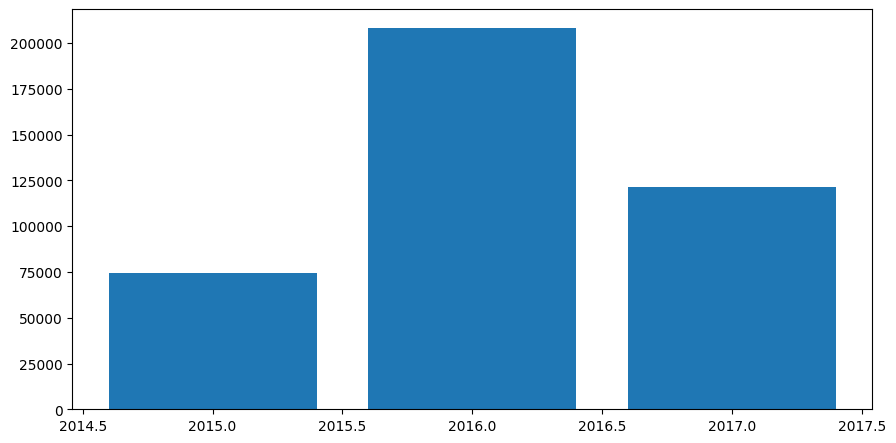

In [45]:
# Графическим путём посмотрим как распределены рецензии
df_for_graph=hotels["review_date_year"].value_counts()

fig=plt.figure(figsize=(8,4))
axes=fig.add_axes([0,0,1,1])

axes.bar(x=df_for_graph.index,height=df_for_graph)

Борльше всего рецензий было сделано в  2016 году

In [46]:
# закодируем признаки  дня недели и названия месяца One-Hot кодированием

# День недели
encoder=ce.OneHotEncoder(cols=["review_date_day_of_week"],use_cat_names=True)

type_bin=encoder.fit_transform(hotels['review_date_day_of_week'])

hotels=pd.concat([hotels,type_bin],axis=1)


# Месяц

encoder=ce.OneHotEncoder(cols=["review_date_month"],use_cat_names=True)

type_bin=encoder.fit_transform(hotels['review_date_month'])

hotels=pd.concat([hotels,type_bin],axis=1)



# Разберём признак days_since_review

In [47]:
# Работа с признаком days_since_review — количество дней между датой проверки и датой очистки;
hotels["days_since_review_count_day"]=hotels["days_since_review"].apply(lambda x: int( re.search(r"\d{1,}", x)[0]))


hotels["days_since_review_count_day"].describe()
# Медиана и Среденее аРЕФМЕТИЧЕСКОЕ МЕНЬШЕ МАКСИМУМА В 2 РАза
# Инициализируем нормализатор MinMaxScaler
# Мега выбросов нет

count    403826.000000
mean        355.779960
std         208.427141
min           0.000000
25%         178.000000
50%         354.000000
75%         527.000000
max         730.000000
Name: days_since_review_count_day, dtype: float64

In [48]:
mm_scaler=preprocessing.MinMaxScaler()

df_mm=mm_scaler.fit_transform(pd.DataFrame(hotels["days_since_review_count_day"]))

df_mm=pd.DataFrame(df_mm,columns=["days_since_review_count_day"])


hotels["days_since_review_count_day_MinMaxScaler"]=df_mm["days_since_review_count_day"]

# Разберём hotel_name — название отеля



In [49]:
hotel_name_hotels_value_counts=hotels["hotel_name"].value_counts().sort_values(ascending=False)

# Отелей слишком много. Нужно отсеять часть названий которые встречаются слишком редко .
# Оставим только не отели которые встречаются почаще. А именно возьмём отели которые стречаются в 5% строк



In [50]:
DF_For_Coding=(hotel_name_hotels_value_counts[hotel_name_hotels_value_counts>hotels.shape[0]*0.05])



нет на столько популярного отеля который бы фигурировал в  5% строк
Поэтому просто возьмём первые 10 отелей  - типо топ . И создадим флаг популярности.

In [51]:
DF_For_Coding=(hotel_name_hotels_value_counts[hotel_name_hotels_value_counts>1000])
DF_For_Coding.sum()

list_famous_Hotels=DF_For_Coding.index
list_famous_Hotels

hotels["hotel_name_famous_bool"]=hotels["hotel_name"].isin( list_famous_Hotels)


hotels["hotel_name_famous"]=0
hotels.loc[hotels[hotels["hotel_name_famous_bool"]].index,["hotel_name_famous"]]=1
hotels.loc[hotels[hotels["hotel_name_famous_bool"]==False].index,["hotel_name_famous"]]=0
hotels["hotel_name_famous"]=hotels["hotel_name_famous"].astype(int)



# Разберём hotel_address  -Нужно достать название страны и Города

In [52]:
# У нас есть столбец со страной проживания рецензента возьмём из него все уникальные значения

list_country=hotels["reviewer_nationality"].value_counts().index
# Уберём пробелы в начале и конце

def strip_str (string :str):
  if string!='':
       return string.strip()
list_country=list(map (strip_str,list_country))


Посмотрим на топ стран из которых родом рецензенты

<BarContainer object of 5 artists>

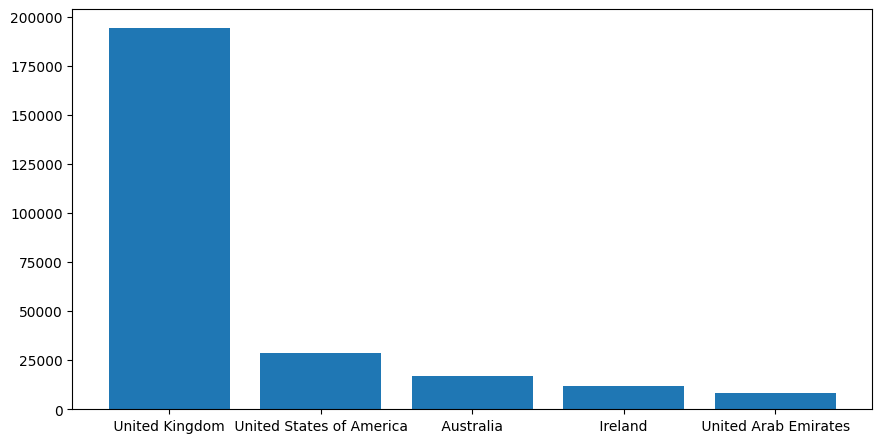

In [53]:
df_for_figure=hotels["reviewer_nationality"].value_counts().sort_values(ascending=False)[:5]
fig=plt.figure(figsize=(8,4))
axes=fig.add_axes([0,0,1,1])
axes.bar(x=df_for_figure.index ,height=df_for_figure)


Видно что у нас  половина рецензентов из Англии добавим флаг англичанина

In [54]:
hotels["reviewer_nationality_United_Kingdom"]=hotels["reviewer_nationality"].apply(lambda x : 1 if x.lower().replace(" ","")=="United Kingdom".lower().replace(" ","")  else 0)



In [55]:
# Список стран Рецензентов код представленный ниже долго выполняется

# чтоб сократить время на частые запуски выполним код котороый ниже 1 раз и надём все страны отели котрых предсталены в таблице



list_country=["United Kingdom","Spain","France","Netherlands","Austria","Italy"]

# Теперь будем перебирать небольшой список стран

In [56]:
hotels["hotel_address"]

# теперь будем проверять наличие названия страны в адресе
# и если название есть то укажем название страны

# функция для проверки названия страны


def take_country(hotel_address, country_name):
      if country_name.lower().replace(" ","") in hotel_address.lower().replace(" ",""):
        return  country_name

hotels["hotel_address_country"]=None


for country_name in list_country:

    hotels.loc[hotels[hotels["hotel_address_country"].isnull()].index,["hotel_address_country"]]=hotels["hotel_address"].apply(take_country,country_name=country_name)





In [57]:
hotels["hotel_address_country"].value_counts()

hotel_address_country
United Kingdom    202122
Spain              49898
France             49790
Netherlands        43578
Austria            31161
Italy              27277
Name: count, dtype: int64

In [58]:
# У нас всего 5 стран для проверки
# это значит 1 мы можем достать название города так как  принцеп формирования адреса в разных странах свой папример у United Kingdom  после города есть 2 3х символьные конструкции
# У Spain перед городом есть 5 цифр
# У France перед городом есть 5 цифр
# У Netherlands перед городом есть 4  цифры
# У Austria перед городом есть 4  цифры
# У Italy перед городом есть 5  цифр

# hotels[hotels["hotel_address_country"]=="Italy"]["hotel_address"].iloc[4545]

In [59]:
# Данная функция  будет вытаскивать  названрие города + какойто признак района

def take_city(row):
      Country_name=row["hotel_address_country"]
      hotel_address=row["hotel_address"]
      City_name="Ошибка поиска города"

      if Country_name=="United Kingdom":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-4:-2]
        City_name=" ".join(City_name)


      if Country_name=="Spain":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-2:]
        City_name=" ".join(City_name)



      if Country_name=="France":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-2:]
        City_name=" ".join(City_name)


      if Country_name=="Netherlands":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-3:]
        City_name=" ".join(City_name)

      if Country_name=="Austria":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-2:]
        City_name=" ".join(City_name)


      if Country_name=="Italy":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-2:]
        City_name=" ".join(City_name)


      return City_name



# hotel_address ="21 Piccadilly Westminster Borough London W1J 0BH United Kingdom"
# Country_name="United Kingdom"


# hotel_address ="Calabria 90 92 Eixample 08015 Barcelona Spain"
# Country_name="Spain"


# hotel_address ="20 Rue Jean Rey 15th arr 75015 Paris France"
# Country_name="France"

# hotel_address ="IJdock 6 Amsterdam City Center 1013 MM Amsterdam Netherlands"
# Country_name="Netherlands"


# hotel_address ="Schlossallee 8 14 Penzing 1140 Vienna Austria"
# Country_name="Austria"

# hotel_address ="Piazza Duca D Aosta 4 6 Central Station 20124 Milan Italy"
# Country_name="Italy"




# take_city(hotel_address , Country_name)

In [60]:
hotels["hotel_address_city_name"]=hotels.apply( take_city,axis=1 )




In [61]:
hotels[["hotel_address_city_name"]].value_counts()

hotel_address_city_name
Borough London             71066
Chelsea London             31705
Camden London              23235
London London              13734
1010 Vienna                10046
                           ...  
1018 GX Amsterdam             24
20141 Milan                   19
1017 JW Amsterdam             15
1230 Vienna                   14
92120 Paris                    8
Name: count, Length: 241, dtype: int64

In [62]:
# Закодируем название страны Бинарным кодированием
bin_encoder=ce.OneHotEncoder(cols=["hotel_address_country"],use_cat_names=True)

type_bin=bin_encoder.fit_transform(hotels["hotel_address_country"])
hotels=pd.concat([hotels,type_bin],axis=1)

# lat — географическая широта отеля;
# lng — географическая долгота отеля.


## Нужно заполнить пропуски

In [63]:
hotels["lng"].isnull().sum()

2642

In [64]:
hotels[["hotel_address","hotel_address_city_name","lat","lng"]][hotels["lng"].isnull()]["hotel_address_city_name"].value_counts()

hotel_address_city_name
1090 Vienna        602
1080 Vienna        540
1020 Vienna        471
75008 Paris        249
1030 Vienna        191
1190 Vienna        159
1160 Vienna        137
08010 Barcelona    124
75018 Paris         48
1110 Vienna         36
75014 Paris         34
08009 Barcelona     29
08011 Barcelona     22
Name: count, dtype: int64

In [65]:
# Из ранее полученного признака Города мы можем достать адрес  и заполнить пропущенную геолокацию

# 1 Получем все города   с пропусками в гео локации

lat_nulls=hotels[hotels["lat"].isnull()]["hotel_address_city_name"].unique()

# 2 Получим для городов указынных выше их гео локации

df_merge_lat_not_null=hotels[(hotels["lat"].isnull()==False) & (hotels["hotel_address_city_name"].isin (lat_nulls) )][["hotel_address_city_name","lat","lng"]]


# 3 получим моду для каждого  города
df_merge_lat_not_null=df_merge_lat_not_null.groupby(by=["hotel_address_city_name"]).agg(lambda x :x.mode())



In [66]:

# 4 В таблице отелей заполним пропуски в гео локации
# так как  значений не много  заполним пропуски используя цикл for

for row_Megge_table in df_merge_lat_not_null.index:

    hotels.loc[  hotels[(hotels["lat"].isnull())& (hotels["hotel_address_city_name"]==row_Megge_table)].index ,  "lat"     ]=(df_merge_lat_not_null.loc[row_Megge_table,"lat"])
    hotels.loc[  hotels[(hotels["lng"].isnull())& (hotels["hotel_address_city_name"]==row_Megge_table)].index ,  "lng"     ]=(df_merge_lat_not_null.loc[row_Megge_table,"lng"])

# Пропуски в столбцах lat  lng  -заполнены

In [67]:
# Уберём у Признака города - индекс района
def take_city_DELL_INDEX(row):
      Country_name=row["hotel_address_country"]
      hotel_address=row["hotel_address"]
      City_name="Ошибка поиска города"

      if Country_name=="United Kingdom":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-3:-2]
        City_name=" ".join(City_name)


      if Country_name=="Spain":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-1:]
        City_name=" ".join(City_name)



      if Country_name=="France":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-1:]
        City_name=" ".join(City_name)


      if Country_name=="Netherlands":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-1:]
        City_name=" ".join(City_name)

      if Country_name=="Austria":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-1:]
        City_name=" ".join(City_name)


      if Country_name=="Italy":
        City_name=hotel_address.replace(Country_name,"").strip().split(" ")[-1:]
        City_name=" ".join(City_name)


      return City_name



In [68]:
hotels["hotel_address_city_name"]=hotels.apply( take_city_DELL_INDEX,axis=1 )


In [69]:
# Закодируем название города Бинарным кодированием
bin_encoder=ce.BinaryEncoder(cols=["hotel_address_city_name"])

type_bin=bin_encoder.fit_transform(hotels["hotel_address_city_name"])
hotels=pd.concat([hotels,type_bin],axis=1)

# Разберём positive_review — положительный отзыв, который рецензент дал отелю

Среди отзывов есть  упоминание

Location - локации

Everything  - всё  

Breakfast  - завтрак

это кондидаты стать отдельными признаками

но для начала надо поработать с текстом и достать их

Так как в одной строке может быть несколько


In [70]:

# Подправим количество слов в столбца где присутстсвутет no positive  - вначале найдём все синонимы а потом изменим на no positive  а дальше заменим кол-во слов на 0

hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().strip())
list_no_positive=["nothing","n a","none"]
hotels.loc[hotels[hotels["positive_review"].isin(list_no_positive)].index,["positive_review"]]="no positive"
hotels.loc[hotels[hotels["positive_review"]=="no positive"].index,["review_total_positive_word_counts"]]=0

hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("the ","").replace("and ","").replace("hotel","").strip())




# Избавимся от слов качества  comfy friendly  comfortable   helpful

# Заменим редко встречающиеся прилогательные на часто
# comfy  и  comfortable и helpful  на good

hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("comfortable ","good").replace("helpful ","good").replace("friendly ","good").replace("comfy ","good").replace( "nice ","good").replace("very good","great") .replace( "fantastic ","great")  .replace( "amazing ","great").strip())

# Добавим столбцы для эмоцианальной окраски  -т.е
# соберём словарь с эмоциональной оценкой


dictHappy={"good":1,
           "great":2,
           "perfect":3,
            "excellent":4
}

hotels["positive_review_level_of_joy"]=1
hotels["positive_review_level_of_joy"]=hotels["positive_review"].apply(lambda x: 2 if "great" in x else  3 if "perfect" in x else  4 if  "excellent" in x else 1)
# Для строк где нет положительного комментария проставим 0
hotels.loc[hotels[hotels["positive_review"]=="no positive"].index,["positive_review_level_of_joy"]]=0
# теперь избавимся от слов эмоциональной окраски в комментариях

# Регулярным вывражением избавимся от определений is great  например
Regex_pattren="((was)|(is)|(were)|(are)) [a-z]{1,}"
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: re.sub(Regex_pattren, "",  x, count=0))



hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("good","").replace("great","").replace("perfect","").replace("excellent","").replace("  "," ").strip())

# У некоторых комментарием есть синонимы - подведём их под единое определение

hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("every thing","everything").replace("all","everything").replace("position","location").replace("rooms","room").replace("beds","bed").replace("food","breakfast").replace("comfort","room").replace("cleanliness","clean").replace("service","staff").strip())





# Вынесем самые популярные теги комментарии в отдельные столбцы

hotels["positive_review_location"]=hotels["positive_review"].apply(lambda x: 1 if "location" in x else 0 )
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("location","").strip())



hotels["positive_review_everything"]=hotels["positive_review"].apply(lambda x: 1 if "everything" in x else 0 )
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("everything","").strip())


hotels["positive_review_Breakfast"]=hotels["positive_review"].apply(lambda x: 1 if "breakfast" in x else 0 )
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("breakfast","").strip())


hotels["positive_review_staff"]=hotels["positive_review"].apply(lambda x: 1 if "staff" in x else 0 )
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("staff","").strip())

hotels["positive_review_staff"]=hotels["positive_review"].apply(lambda x: 1 if "clean" in x else 0 )
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("clean","").strip())

hotels["positive_review_staff"]=hotels["positive_review"].apply(lambda x: 1 if "room" in x else 0 )
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("room","").strip())

hotels["positive_review_staff"]=hotels["positive_review"].apply(lambda x: 1 if "bed" in x else 0 )
hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("bed","").strip())

# Избавимся от упоминание ранее добавленных слов
# hotels["positive_review"]=hotels["positive_review"].apply(lambda x: x.lower().replace("location","").replace("everything","").replace("breakfast","").replace("staff","").strip())


hotels["positive_review"].value_counts().head(30)

positive_review
                   57601
no positive        30106
helpful             1496
able                1363
lovely              1206
facilities          1125
friendly            1074
very                 993
view                 750
quiet                740
of                   730
value for money      679
spacious             636
comfy                623
bath                 617
nice                 590
s                    588
modern               578
shower               573
size                 556
very helpful         495
reception            467
price                444
central              438
decor                437
beautiful            409
convenient           399
big                  384
it                   382
very able            355
Name: count, dtype: int64

# Разберём negative_review — отрицательный отзыв, который рецензент дал отелю;

In [71]:

hotels["negative_review"].value_counts().head(30)
hotels.groupby(by=["negative_review"])["review_total_negative_word_counts"].agg(['median','count']).sort_values(by=['count'],ascending=False).head(30)

,median,count
negative_review,,
No Negative,0.0,106844
Nothing,2.0,11970
Nothing,3.0,3322
nothing,2.0,1811
N A,3.0,861
None,2.0,826
,2.0,658
N a,3.0,454
Breakfast,2.0,350


In [72]:
# Среди негативных комментариев есть положительные комментарии с эмоциональной окраской

hotels["negative_review_level_of_joy"]=hotels["negative_review"].apply(lambda x: 2 if "great" in x else  3 if "perfect" in x else  4 if  "excellent" in x else 0)




In [73]:
# Перенесём все положительные оценки в ранее созданный столбец positive_review_level_of_joy
hotels["positive_review_level_of_joy"]=hotels.apply(lambda Row: Row["negative_review_level_of_joy"] if Row["negative_review_level_of_joy"]>Row["negative_review_level_of_joy"] else Row["positive_review_level_of_joy"]  ,axis =1)

In [74]:



# Заменим комментарии которые положительные  являются нейтральными  но почемуто попали в столбец негативных

hotels["negative_review"]=hotels["negative_review"].apply(lambda x: x.lower().strip())
list_no_negative=["nothing","n a","none","nothing really","all good","nothing at all","na","liked everything"
,"i liked everything","everything was good","everything was perfect","nothing to dislike","everything was great","non","nothing it was perfect","everything was fine"
,"all was good","nothing all good","nothing everything was perfect","absolutely nothing","no complaints","nothing everything was great"]

hotels.loc[hotels[hotels["negative_review"].isin(list_no_negative)].index,["negative_review"]]="no negative"
hotels.loc[hotels[hotels["negative_review"]=="no negative"].index,["review_total_negative_word_counts"]]=0

In [75]:
# Для удобства поиска напишем функцию которая будет находить все строки в которых существует отпределённое слово
def find_text(df,coll_name,find_str):
    set_str=set(df[coll_name].apply(lambda x : x if find_str in x else "" ))
    return set_str




In [76]:

# Заменим the  на пустоту
hotels["negative_review"]=hotels["negative_review"].apply(lambda x: x.lower().replace("the ","").strip())

# Заменим синонимы слова everything  на него же
hotels["negative_review"]=hotels["negative_review"].apply(lambda x: x.lower().replace("nothing not to like","everything").strip())

hotels["negative_review_location"]=hotels["negative_review"].apply(lambda x: 1 if "location" in x else 0 )
# hotels["negative_review"]=hotels["negative_review"].apply(lambda x: x.lower().replace("location","").strip())


# hotels["negative_review"]=hotels["negative_review"].apply(lambda x: x.lower().replace("small rooms","room").replace("small room","room").replace("room size","room").replace("room was very small","room").replace("room very small","room").replace("room was small","room").replace("room size","room").strip())
hotels["negative_review_room"]=hotels["negative_review"].apply(lambda x: 1 if "room" in x else 0 )
# hotels["negative_review"]=hotels["negative_review"].apply(lambda x: x.lower().replace("room","").strip())



In [77]:
hotels["negative_review"].value_counts().head(30)
hotels.groupby(by=["negative_review"])["review_total_negative_word_counts"].agg(['mean','count']).sort_values(by=['count'],ascending=False).head(30)


,mean,count
negative_review,,
no negative,0.000000,131032
,2.000000,658
breakfast,2.256272,558
small room,3.168675,498
location,2.248473,491
everything,3.094737,475
price,2.420804,423
nil,2.054745,274
small rooms,3.202206,272


# Разберём признаки количество слов в отзыве
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.

In [78]:
# С признаком количества слов желательно что то сделать  т.к  в нем среднее значение слов в отзыве 25 а  максимальное в несколько раз больше Проведём нормализацию RobustScaler

r_scaler=preprocessing.RobustScaler()

df_r=r_scaler.fit_transform(hotels[["review_total_positive_word_counts"]])

df_r = pd.DataFrame(df_r, columns=["review_total_positive_word_counts_RobustScaler"])

# Но так как нам нужны только положительные отзывы сместим результат в право чтоб самое минимальное значение было нулём

hotels['review_total_positive_word_counts_RobustScaler']=(df_r["review_total_positive_word_counts_RobustScaler"]+np.abs(df_r["review_total_positive_word_counts_RobustScaler"].min()))


In [79]:
# С признаком количества слов желательно что то сделать  т.к  в нем среднее значение слов в отзыве 25 а  максимальное в несколько раз больше Проведём нормализацию RobustScaler

r_scaler=preprocessing.RobustScaler()

df_r=r_scaler.fit_transform(hotels[["review_total_negative_word_counts"]])

df_r = pd.DataFrame(df_r, columns=["review_total_negative_word_counts_RobustScaler"])

# Но так как нам нужны только положительные отзывы сместим результат в лево  чтоб самое большое значение было 0
hotels['review_total_negative_word_counts_RobustScaler']=(df_r["review_total_negative_word_counts_RobustScaler"]-np.abs(df_r["review_total_negative_word_counts_RobustScaler"].max()))



# Разберём additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

In [80]:
# Добавим коэффициент показывающий сооношение общего количества отзывов и количества отзывов без комментария

# 1 Поймём за какой период были отзывы без коммента

hotels.groupby(by=["hotel_address"])[["additional_number_of_scoring","total_number_of_reviews_reviewer_has_given","total_number_of_reviews"]].agg([ 'min',"max",'count']).sort_values(by=[("total_number_of_reviews_reviewer_has_given","count")],ascending=False)

additional_number_of_scoring  \
                                                                            min   
hotel_address                                                                     
1 Inverness Terrace Westminster Borough London ...                         1274   
Wrights Lane Kensington and Chelsea London W8 5...                         1172   
1 Waterview Drive Greenwich London SE10 0TW Uni...                         1258   
1 Addington Street Lambeth London SE1 7RY Unite...                         1322   
27 Devonshire Terrace Westminster Borough Londo...                         1243   
...                                                                         ...   
8 rue d Anjou 8th arr 75008 Paris France                                     10   
Filmteichstra e 5 10 Favoriten 1100 Vienna Austria                           13   
13 Rue Fran ois Ory 92120 Paris France                                        6   
Via Palmanova 153 20132 Milan Italy                                          12   
Johann Staud Stra e 32 16 Ottakring 1160 Vienna...                            7   

                                                                \
                                                     max count   
hotel_address                                                    
1 Inverness Terrace Westminster Borough London ...  1274  2545   
Wrights Lane Kensington and Chelsea London W8 5...  1172  2339   
1 Waterview Drive Greenwich London SE10 0TW Uni...  1258  2262   
1 Addington Street Lambeth London SE1 7RY Unite...  1322  1922   
27 Devonshire Terrace Westminster Borough Londo...  1243  1919   
...                                                  ...   ...   
8 rue d Anjou 8th arr 75008 Paris France              10     9   
Filmteichstra e 5 10 Favoriten 1100 Vienna Austria    13     9   
13 Rue Fran ois Ory 92120 Paris France                 6     8   
Via Palmanova 153 20132 Milan Italy                   12     5   
Johann Staud Stra e 32 16 Ottakring 1160 Vienna...     7     5   

                                                   total_number_of_reviews_reviewer_has_given  \
                                                                                          min   
hotel_address                                                                                   
1 Inverness Terrace Westminster Borough London ...                                          1   
Wrights Lane Kensington and Chelsea London W8 5...                                          1   
1 Waterview Drive Greenwich London SE10 0TW Uni...                                          1   
1 Addington Street Lambeth London SE1 7RY Unite...                                          1   
27 Devonshire Terrace Westminster Borough Londo...                                          1   
...                                                                                       ...   
8 rue d Anjou 8th arr 75008 Paris France                                                    1   
Filmteichstra e 5 10 Favoriten 1100 Vienna Austria                                          5   
13 Rue Fran ois Ory 92120 Paris France                                                      1   
Via Palmanova 153 20132 Milan Italy                                                         1   
Johann Staud Stra e 32 16 Ottakring 1160 Vienna...                                          1   

                                                               \
                                                    max count   
hotel_address                                                   
1 Inverness Terrace Westminster Borough London ...   73  2545   
Wrights Lane Kensington and Chelsea London W8 5...  106  2339   
1 Waterview Drive Greenwich London SE10 0TW Uni...   48  2262   
1 Addington Street Lambeth London SE1 7RY Unite...   48  1922   
27 Devonshire Terrace Westminster Borough Londo...   90  1919   
...                                                 ...   ...   
8 rue d Anjou 8th a

In [81]:
# Соберём табилицу название отеля и коэф  который равен   additional_number_of_scoring   делённый на сумму (additional_number_of_scoring + total_number_of_reviews_reviewer_has_given + количество комментариев для данного отеля )

MergeTable=hotels.groupby(by=["hotel_name"])[["additional_number_of_scoring","total_number_of_reviews_reviewer_has_given","total_number_of_reviews","average_score"]].agg([ 'min','max','count',"nunique"])
MergeTable["additional_number_of_scoring_total_number_of_reviews"]=    MergeTable[("additional_number_of_scoring","min")] /(      + MergeTable[("total_number_of_reviews","min")])
MergeTable.sort_values(by=["additional_number_of_scoring_total_number_of_reviews"],ascending=False)

MergeTable=MergeTable["additional_number_of_scoring_total_number_of_reviews"].sort_values()

In [82]:
# Теперь смержим основную таблицу и коффициент соотношения additional_number_of_scoring   к  total_number_of_reviews
hotels=hotels.merge(MergeTable,left_on=["hotel_name"],right_index=True)

In [83]:
hotels[["hotel_name","additional_number_of_scoring","total_number_of_reviews","additional_number_of_scoring_total_number_of_reviews"]].sort_values(by=["additional_number_of_scoring","additional_number_of_scoring_total_number_of_reviews"])

,hotel_name,additional_number_of_scoring,total_number_of_reviews,additional_number_of_scoring_total_number_of_reviews
17880,XO Hotel,1,49,0.020408
87175,XO Hotel,1,49,0.020408
152651,XO Hotel,1,49,0.020408
175199,XO Hotel,1,49,0.020408
221870,XO Hotel,1,49,0.020408
...,...,...,...,...
403208,Britannia International Hotel Canary Wharf,2682,9086,0.295179
403288,Britannia International Hotel Canary Wharf,2682,9086,0.295179
403408,Britannia International Hotel Canary Wharf,2682,9086,0.295179
403622,Britannia International Hotel Canary Wharf,2682,9086,0.295179


# Разберём hotel_name — название отеля;

In [84]:
hotels["hotel_name"].value_counts()>hotels.shape[0]*0.01
# hotel_name просто удалим  т.к тут нет  часто встречающихся отелей

hotel_name
Grand Royale London Hyde Park                False
Holiday Inn London Kensington                False
Intercontinental London The O2               False
Park Plaza County Hall London                False
Park Grand Paddington Court                  False
                                             ...  
MARQUIS Faubourg St Honor Relais Ch teaux    False
Hotel Eitlj rg                               False
Mercure Paris Porte d Orleans                False
Hotel Gallitzinberg                          False
Ibis Styles Milano Palmanova                 False
Name: count, Length: 1492, dtype: bool

# Разберём reviewer_nationality — страна рецензента



In [85]:
# Поработаем с признаком reviewer_nationality — страна рецензента;

hotels["reviewer_nationality"].value_counts()
# Закодируем признак страны бинарным кодированием


bin_encoder=ce.BinaryEncoder(cols="reviewer_nationality")
bin_encoder
type_bin=bin_encoder.fit_transform(hotels["reviewer_nationality"])
hotels=pd.concat([hotels,type_bin],axis=1)



In [86]:
# добавим признак землячества - т.е если в адресе отеля есть название  страны речензента поставим 0  если нет то 1
hotels["hotel_address_home"]=  hotels.apply (lambda row: 0 if  row["reviewer_nationality"].lower() in row["hotel_address"].lower() else 1 , axis=1)

In [87]:
hotels[["hotel_address_home","reviewer_nationality","hotel_address"]]

,hotel_address_home,reviewer_nationality,hotel_address
0,1,United Kingdom,Stratton Street Mayfair Westminster Borough Lo...
1,1,United Kingdom,130 134 Southampton Row Camden London WC1B 5AF...
2,1,China,151 bis Rue de Rennes 6th arr 75006 Paris France
3,1,United Kingdom,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4,1,France,Via Mecenate 121 20138 Milan Italy
...,...,...,...
403821,1,Greece,Viale Monza 132 Distretto Viale Monza 20127 Mi...
403822,1,United States of America,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...
403823,1,New Zealand,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...
403824,1,Australia,Corso Concordia 1 Milan City Center 20129 Mila...


# Удалим лишние столбцы которые больше не понадобятся

In [88]:


# Удалим вспомогательный столбецы
hotels=hotels.drop(["index_from_hotels","hotel_name_famous_bool"],axis=1)


# УДалим столбец Тегов
hotels.drop(["tags","tags_list"],inplace=True,axis=1)


# Удалим признаки  Появившиеся при работе с датой review_date и  days_since_review


hotels.drop(["review_date","review_date_year","review_date_day_of_week","review_date_month"],inplace=True,axis=1)

# Удалим название отеля

hotels.drop(["hotel_name"],inplace=True,axis=1)

# Удалим review_total_negative_word_counts  и  review_total_positive_word_counts

hotels.drop(["review_total_positive_word_counts","review_total_negative_word_counts"],inplace=True,axis=1)


# Удалим   days_since_review  и  days_since_review_count_day
hotels.drop(["days_since_review","days_since_review_count_day"],inplace=True,axis=1)

# Удалим   additional_number_of_scoring  и  total_number_of_reviews
hotels.drop(["additional_number_of_scoring","total_number_of_reviews"],inplace=True,axis=1)


In [89]:
# Удалим столбцы с типом данных object

drop_list=hotels.select_dtypes(['object']).columns

hotels.drop(drop_list,axis=1,inplace=True)



hotels.head()


,average_score,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,TestFlag,Tags_Count,Tags_Leisure trip,Tags_Submitted from a mobile device,Tags_Couple,...,additional_number_of_scoring_total_number_of_reviews,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,hotel_address_home
0,8.4,7,10.0,51.507894,-0.143671,0,5,1.0,1.0,1.0,...,0.291374,0,0,0,0,0,0,0,1,1
1,8.3,14,6.3,51.521009,-0.123097,0,4,0.0,0.0,1.0,...,0.219691,0,0,0,0,0,0,0,1,1
2,8.9,14,7.5,48.845377,2.325643,0,5,1.0,1.0,0.0,...,0.078818,0,0,0,0,0,0,1,0,1
3,7.5,8,10.0,48.888697,2.394540,0,4,1.0,0.0,0.0,...,0.056013,0,0,0,0,0,0,0,1,1
4,8.0,1,10.0,45.448188,9.257046,0,5,0.0,1.0,0.0,...,0.065339,0,0,0,0,0,0,1,1,1


# Отбор признаков .
Если какието признаки слишком сильно корелируют друг с другом то один из них нужно удалять

После того как было создано много признаков и закодированно их надо разделить на  категориальные и числовые

In [90]:
# Признаков много поэтому мы не можем использовать тепловую карту она не информативна
# Удалим из таблици целевой признак

hotels_corr=hotels.drop(['reviewer_score'],axis=1).corr(method='spearman')[hotels.corr()!=1]



hotels_corr_max=hotels_corr.max().abs().sort_values(ascending=False)



In [91]:

hotels_corr_max=hotels_corr_max[hotels_corr_max>0.7]


# В таблицу с максимальными кореляциями могут попасть столбцы которые появились за счёт бинарного кодирования  - это не хорошо  такие столбцы надо из нее исключить
# Найти такой признак можно  с помощью Regex  их шаблон следующий у них на конце есть  _число
Regex_pattern=".{1,}_\d{1,}$"

index_hotels_corr_max=hotels_corr_max.index
index_hotels_corr_max=pd.DataFrame(index_hotels_corr_max)
index_hotels_corr_max["bin_collstatus"]=index_hotels_corr_max[0].apply(lambda x  :   re.fullmatch(Regex_pattern,   x) is None)
index_hotels_corr_max=index_hotels_corr_max[index_hotels_corr_max["bin_collstatus"]][0]

# теперь  в выборку не будут попадать столбцы задействованные в бинарном кодировании

In [92]:
index_hotels_corr_max

0                                           Tags_Count
1                  Tags_Submitted from a mobile device
2                 hotel_address_country_United Kingdom
3    additional_number_of_scoring_total_number_of_r...
Name: 0, dtype: object

У нас есть  4 скорелированных признака  ,

но  Tags_Count  имеет сильную кореляцию  с Tags_Submitted from a mobile device    но  Tags_Count  -числовой а Tags_Submitted from a mobile device  -Бинарный

hotel_address_country_United Kingdom  корелирует  с признаком additional_number_of_scoring_total_number_of_reviews    тут так же  hotel_address_country_United Kingdom  - бинарный а  additional_number_of_scoring_total_number_of_reviews  -непрерывный - числовой

lat -сильно корелирует с признаком hotel_address_city_name_2  - это признак часть бинарного кодирования  

In [93]:
hotels_corr['lat'].sort_values()

hotel_address_country_Spain                            -0.569989
lng                                                    -0.335616
hotel_address_country_Italy                            -0.319483
hotel_address_country_Austria                          -0.270768
hotel_address_country_France                           -0.220947
                                                          ...   
hotel_name_famous                                       0.259498
hotel_address_country_United Kingdom                    0.491818
hotel_address_country_Netherlands                       0.537405
additional_number_of_scoring_total_number_of_reviews    0.573203
lat                                                          NaN
Name: lat, Length: 73, dtype: float64

In [94]:
ColForDel=hotels_corr_max[hotels_corr_max>0.7].index
ColForDel

Index(['Tags_Count', 'Tags_Submitted from a mobile device',
       'hotel_address_country_United Kingdom',
       'additional_number_of_scoring_total_number_of_reviews',
       'hotel_address_city_name_2'],
      dtype='object')

так как ранее  мы основывались на значении максимальной кореляции  то первой строкой всегда будет признак с которым данный столбец корелирует сильнее всего

но один признак может сильно корелировать и с другими признаками - поэтому нужно  проверить 2 условия
1  Со сколькими признаками сильно корелирует текущий признак (>0.7)
2 Если количество признаком с сильной кореляцией одинаково в сравнении с аналогичным значением у признака который с текущим корелирует максимально
то  мы найдём сумму кореляций с другими  признаками и в "живых" останется тот у кого она больше

In [95]:
# надо выбрать

hotels_corr["Tags_Count"].abs().sort_values(ascending=False)




Tags_Submitted from a mobile device           0.954512
Tags_Leisure trip                             0.225869
Tags_Business trip                            0.123544
total_number_of_reviews_reviewer_has_given    0.118522
Tags_Solo traveler                            0.111403
                                                ...   
review_date_month_May                         0.001051
Tags_Stayed 3 nights                          0.000561
review_date_month_February                    0.000432
Tags_Standard Double Room                     0.000075
Tags_Count                                         NaN
Name: Tags_Count, Length: 73, dtype: float64

# Раздел с моделью

In [96]:
# Вывести столбцы с пропусками

hotels.isnull().sum().sort_values().sum()

128935

In [97]:
# Соберём в словарь значения средних арефметических для числовых признаков

dict_for_fillna=dict(hotels[hotels.select_dtypes(['int64', 'float64']).columns].mean())


In [98]:
# Заполним пропусвки  средним арефметическим
hotels.fillna(dict_for_fillna,inplace=True)

In [99]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score']

In [100]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [101]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [102]:
y=y.astype('int')

# Оценим влияние категориальных признаков на целевую переменную

<Axes: >

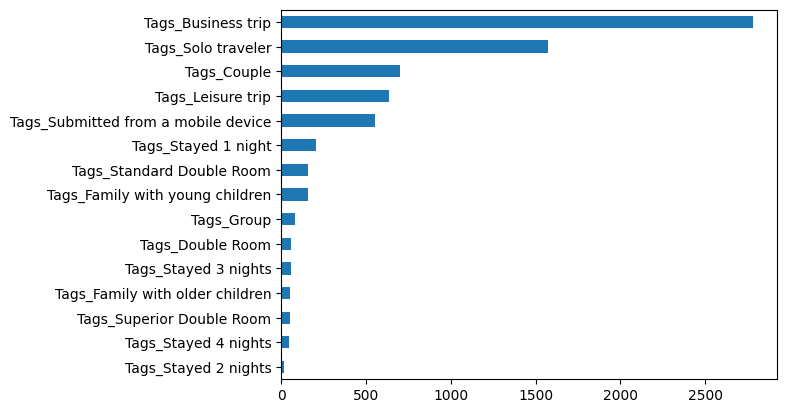

In [103]:
# ОЦеним влияние Tags

List_FamosTags=[

"Tags_Leisure trip" ,
"Tags_Submitted from a mobile device",
"Tags_Couple",
"Tags_Stayed 1 night",
"Tags_Stayed 2 nights",
"Tags_Solo traveler",
"Tags_Stayed 3 nights",
"Tags_Business trip",
"Tags_Group",
"Tags_Family with young children",
"Tags_Stayed 4 nights",
"Tags_Double Room",
"Tags_Standard Double Room",
"Tags_Superior Double Room",
"Tags_Family with older children"
]

cat_cols =List_FamosTags


from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

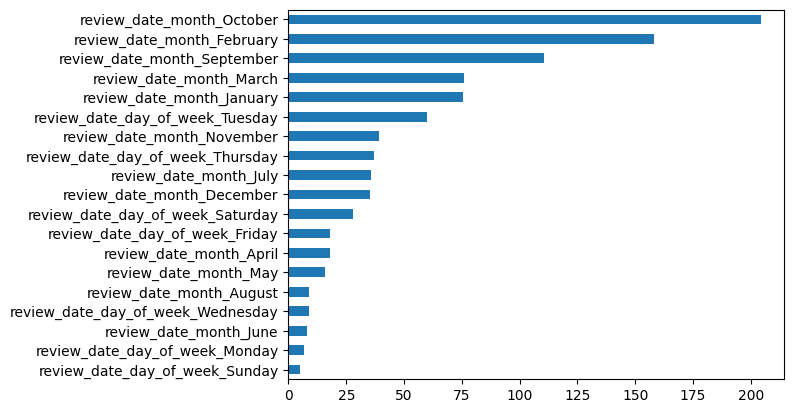

In [104]:
List_review_date= [
 "review_date_day_of_week_Friday",
 "review_date_day_of_week_Thursday",
 "review_date_day_of_week_Tuesday",
 "review_date_day_of_week_Saturday",
 "review_date_day_of_week_Wednesday",
 "review_date_day_of_week_Monday",
 "review_date_day_of_week_Sunday",
 "review_date_month_February",
 "review_date_month_January",
 "review_date_month_October",
 "review_date_month_September",
 "review_date_month_March",
 "review_date_month_December",
 "review_date_month_May",
 "review_date_month_November",
 "review_date_month_June",
 "review_date_month_July",
 "review_date_month_April",
 "review_date_month_August"
 ]

cat_cols =List_review_date




imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

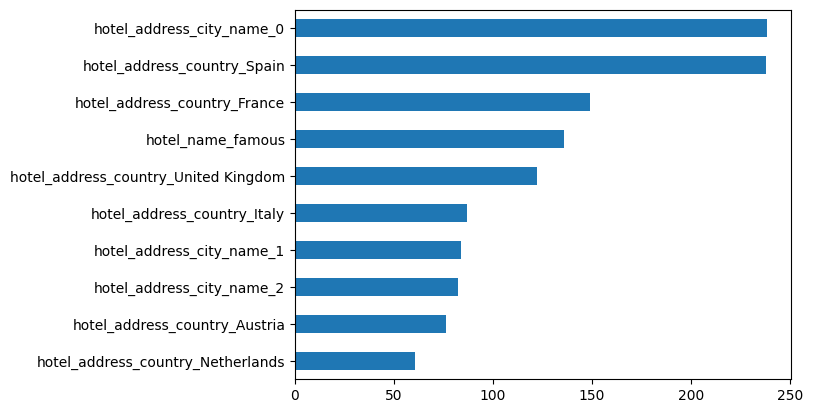

In [105]:
List_hotel_name= ["hotel_name_famous",
"hotel_address_country_United Kingdom",
"hotel_address_country_France",
"hotel_address_country_Netherlands",
"hotel_address_country_Italy",
"hotel_address_country_Austria",
"hotel_address_country_Spain",
"hotel_address_city_name_0",
"hotel_address_city_name_1",
"hotel_address_city_name_2"]



cat_cols =List_hotel_name




imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

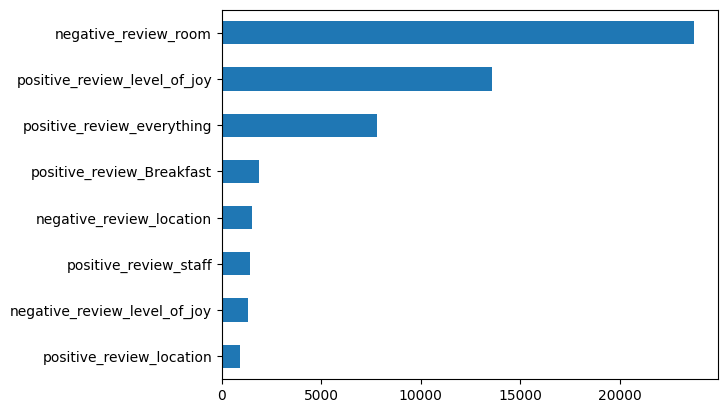

In [106]:
List_positive_review= ["positive_review_level_of_joy",
"positive_review_location",
"positive_review_everything",
"positive_review_Breakfast",
"positive_review_staff",
"negative_review_level_of_joy",
"negative_review_location",
"negative_review_room"]

cat_cols =List_positive_review




imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')



<Axes: >

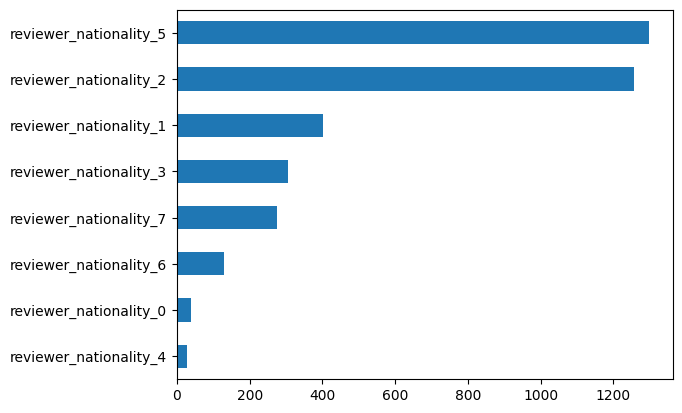

In [107]:

List_positive_reviewer_nationality= ["reviewer_nationality_0",
"reviewer_nationality_1",
"reviewer_nationality_2",
"reviewer_nationality_3",
"reviewer_nationality_4",
"reviewer_nationality_5",
"reviewer_nationality_6",
"reviewer_nationality_7"]

cat_cols =List_positive_reviewer_nationality




imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


In [108]:
# Достанем из таблицы Отелей  все столбцы которые являются категориальными - это не сложно  -Количество уникальных значений в  них 2   это 0 и 1

List_CAtColls=hotels.nunique()[hotels.nunique()<=2].index


62


<Axes: >

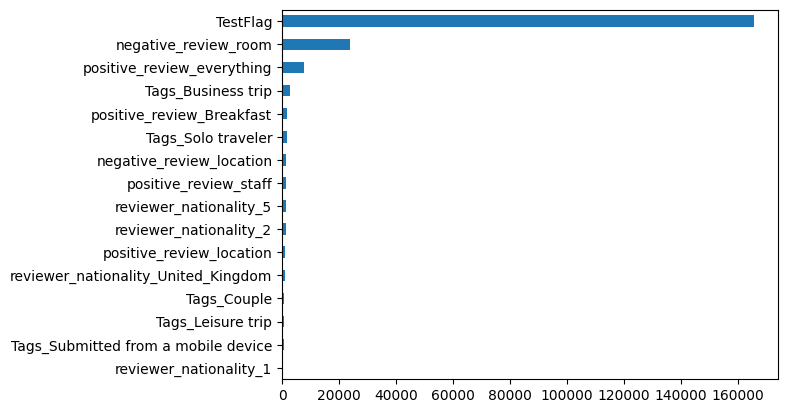

In [109]:
# List_CAtColls=[

# "Tags_Leisure trip" ,
# "Tags_Submitted from a mobile device",
# "Tags_Couple",
# "Tags_Stayed 1 night",
# "Tags_Stayed 2 nights",
# "Tags_Solo traveler",
# "Tags_Stayed 3 nights",
# "Tags_Business trip",
# "Tags_Group",
# "Tags_Family with young children",
# "Tags_Stayed 4 nights",
# "Tags_Double Room",
# "Tags_Standard Double Room",
# "Tags_Superior Double Room",
# "Tags_Family with older children",
#  "review_date_day_of_week_Friday",
#  "review_date_day_of_week_Thursday",
#  "review_date_day_of_week_Tuesday",
#  "review_date_day_of_week_Saturday",
#  "review_date_day_of_week_Wednesday",
#  "review_date_day_of_week_Monday",
#  "review_date_day_of_week_Sunday",
#  "review_date_month_February",
#  "review_date_month_January",
#  "review_date_month_October",
#  "review_date_month_September",
#  "review_date_month_March",
#  "review_date_month_December",
#  "review_date_month_May",
#  "review_date_month_November",
#  "review_date_month_June",
#  "review_date_month_July",
#  "review_date_month_April",
#  "review_date_month_August",
#  "hotel_name_famous",
# "hotel_address_country_United Kingdom",
# "hotel_address_country_France",
# "hotel_address_country_Netherlands",
# "hotel_address_country_Italy",
# "hotel_address_country_Austria",
# "hotel_address_country_Spain",
# "hotel_address_city_name_0",
# "hotel_address_city_name_1",
# "hotel_address_city_name_2",
# "positive_review_level_of_joy",
# "positive_review_location",
# "positive_review_everything",
# "positive_review_Breakfast",
# "positive_review_staff",
# "negative_review_level_of_joy",
# "negative_review_location",
# "negative_review_room",
# "reviewer_nationality_0",
# "reviewer_nationality_1",
# "reviewer_nationality_2",
# "reviewer_nationality_3",
# "reviewer_nationality_4",
# "reviewer_nationality_5",
# "reviewer_nationality_6",
# "reviewer_nationality_7"]


print(len(List_CAtColls))

cat_cols =List_CAtColls

# chi2(X[cat_cols], y)[0]


from sklearn.feature_selection import chi2 # хи-квадрат

# Из всех признаков возьмём только 15 первых самых влиятельных

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols).sort_values(ascending=False).iloc[0:16]
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [110]:
imp_cat

reviewer_nationality_1                    401.061475
Tags_Submitted from a mobile device       556.483843
Tags_Leisure trip                         636.571053
Tags_Couple                               700.730953
reviewer_nationality_United_Kingdom       909.890394
positive_review_location                  915.829725
reviewer_nationality_2                   1258.326781
reviewer_nationality_5                   1299.294919
positive_review_staff                    1399.608917
negative_review_location                 1506.902219
Tags_Solo traveler                       1573.459626
positive_review_Breakfast                1879.815592
Tags_Business trip                       2785.020762
positive_review_everything               7786.899712
negative_review_room                    23736.054020
TestFlag                               165711.656462
dtype: float64

Возьмём первые 15  признаков по влиянию на целевую переменную
Среди этих признаков есть признаки которые учавствовали в бинарном кодировании. Надо забрать признак со всеми его столбцами

In [111]:
# Достанем из столбца самых влиятельных  признаков признаки из Бинарного кодироввания
# Они имеют шаблон  у них на конце всегда есть число

Regex_pattern=".{1,}_\d{1,}$"



imp_cat=pd.DataFrame(imp_cat)

# index_hotels_corr_max=hotels_corr_max.index
# index_hotels_corr_max=pd.DataFrame(index_hotels_corr_max)
# index_hotels_corr_max["bin_collstatus"]=index_hotels_corr_max[0].apply(lambda x  :   re.fullmatch(Regex_pattern,   x) is None)
# index_hotels_corr_max=index_hotels_corr_max[index_hotels_corr_max["bin_collstatus"]][0]
imp_cat["index_names"]=imp_cat.index

imp_cat["din_colls"]=imp_cat["index_names"].apply(lambda x  :   re.fullmatch(Regex_pattern,   x) is None)

# Получим список тех столбцов в которые учавствовали в бинарном кодировании
list_of_bin_index=imp_cat[imp_cat["din_colls"]==False].index


# Теперь "оторвём" у них число
Regex_pattern_2="_\d{1,}$"


imp_cat.loc[list_of_bin_index,"index_names"]=imp_cat.loc[list_of_bin_index,"index_names"].apply(lambda x: re.sub(Regex_pattern_2, "", x , count=0)  )

# сОБЕРЁМ ВО МНОЖЕСТВО ПОЛУЧИВШИЕСЯ НАЗВАНИЯ

set_of_bin_index=set(imp_cat[imp_cat["din_colls"]==False]["index_names"])




In [112]:
# Теперь достанем все названия столбцов  из бинарного кодирования соответствущие данному шаблону

itog_list=[]

name_Bin_Coll='reviewer_nationality'


for name_Bin_Coll  in set_of_bin_index:

  Regex_pattern=name_Bin_Coll+"_\d{1,}$"
  pattern=re.compile(Regex_pattern)

  cleaned_list=[item for item in hotels.columns if  pattern.match(item)]
  itog_list=itog_list + cleaned_list



In [113]:
# Соберём в список  все названия столбцов которые  максимально влияют на целевой столбец

List_itog_bin_CaT_coll=list(set(itog_list)|set(imp_cat.index))

List_itog_bin_CaT_coll

['Tags_Business trip',
 'negative_review_location',
 'positive_review_location',
 'Tags_Solo traveler',
 'Tags_Leisure trip',
 'reviewer_nationality_3',
 'Tags_Couple',
 'reviewer_nationality_5',
 'TestFlag',
 'reviewer_nationality_United_Kingdom',
 'negative_review_room',
 'positive_review_Breakfast',
 'reviewer_nationality_6',
 'positive_review_everything',
 'Tags_Submitted from a mobile device',
 'reviewer_nationality_1',
 'reviewer_nationality_7',
 'reviewer_nationality_4',
 'reviewer_nationality_2',
 'reviewer_nationality_0',
 'positive_review_staff']

# Оценим влияние непрерывных признаков на целевую переменную

In [114]:
# Достанем из таблицы оставшиеся  столбцы и убедимся что остались только не прерывные признаки

list_Num_Colls=set(hotels.columns)-set(List_CAtColls)
list_Num_Colls.remove('reviewer_score')
list_Num_Colls=list(list_Num_Colls)

<Axes: >

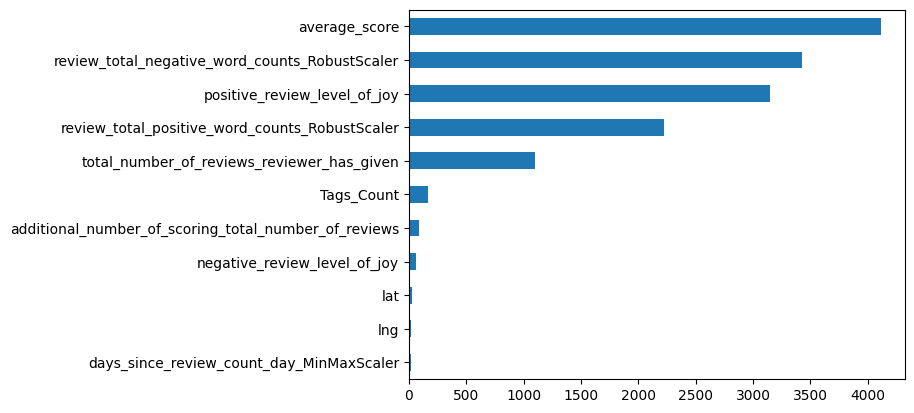

In [115]:
from sklearn.feature_selection import f_classif # anova

num_cols = list_Num_Colls


imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Так как на надо выбрать только влиятельные признаки то будем сравнивать их со среднем аремфетическим - так отстоющие точно отсеятся

In [116]:
# Заберём только те столбцы которые больше стредненего аремфметичкеского умноженного на 0.5
list_Num_Colls=list(imp_num[imp_num>imp_num.mean()*0.5].index)
# И добавим тестовый флаг


In [117]:
# Соберём в один список все элементы

itog_list=List_itog_bin_CaT_coll+list_Num_Colls


In [118]:

if ("TestFlag" in  itog_list)==False:
    print("Добавим тестовый флаг если его не было в итоговом списке столбцов ")
    list_Num_Colls.append("TestFlag")

In [119]:
# теперь округлим числовые признаки до 2 знаков после запятой
hotels[list_Num_Colls]=hotels[list_Num_Colls].round(2)

# Заного переопределим модель

In [120]:
itog_list.append("reviewer_score")

# Переопределяем таблицу отели

hotels=hotels[itog_list]



In [121]:


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)


# Разделим признаки на тестовые и тренировачные
train_hotels=hotels[hotels["TestFlag"]==0].drop(['TestFlag'], axis=1)



test_hotels=hotels[hotels["TestFlag"]==1].drop(['TestFlag'], axis=1)
# Оставим в X только ранее отобранные признаки
X = train_hotels.drop(['reviewer_score'], axis=1)
y = train_hotels['reviewer_score']


# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [122]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)


MAPE: 0.14138286324223787  -было - чем меньше тем лучше
0.10-  это хороший результат

0.1356038539096172  - переработал теги

0.1348252196321253  - добавил признак накрутки оценки


разобрали признак города  0.13484628373241422

разбор признака  положительный  комментарий    0.13198419052564622

разбор признака  отрицательный   комментарий 0.12936184744934814


Приравнивание выбросов к 1 й и 3й квантили сответственно 0.13551607852346315

После удаления признаков и приравнения оставшихся выбросов к 1й и 3й квантили 0.12888070628273923

Просто удаление  лишних  строк 0.12823455796930133



In [123]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12707680177386566


In [124]:
test_hotels

,Tags_Business trip,negative_review_location,positive_review_location,Tags_Solo traveler,Tags_Leisure trip,reviewer_nationality_3,Tags_Couple,reviewer_nationality_5,reviewer_nationality_United_Kingdom,negative_review_room,...,reviewer_nationality_4,reviewer_nationality_2,reviewer_nationality_0,positive_review_staff,total_number_of_reviews_reviewer_has_given,review_total_positive_word_counts_RobustScaler,positive_review_level_of_joy,review_total_negative_word_counts_RobustScaler,average_score,reviewer_score
274891,0.0,0,0,0.0,1.0,0,1.0,0,1,0,...,0,0,0,0,1,4.13,2,-17.50,8.1,8.53057
274892,0.0,0,0,0.0,1.0,0,0.0,0,0,1,...,1,1,0,0,7,0.00,0,-19.60,8.6,8.53057
274893,1.0,0,0,1.0,0.0,0,0.0,0,0,0,...,1,0,0,0,15,0.33,1,-19.95,8.3,8.53057
274894,0.0,0,0,0.0,1.0,0,1.0,0,0,0,...,1,0,0,0,9,1.80,4,-20.10,9.1,8.53057
274895,1.0,0,0,1.0,0.0,0,0.0,0,1,0,...,0,0,0,0,2,0.47,1,-20.10,9.1,8.53057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403821,1.0,0,0,0.0,0.0,1,1.0,1,0,0,...,0,1,0,0,14,0.27,1,-20.10,8.1,8.53057
403822,0.0,0,1,0.0,1.0,0,1.0,0,0,0,...,1,0,0,0,1,1.60,2,-20.10,7.8,8.53057
403823,1.0,0,1,1.0,0.0,1,0.0,1,0,1,...,1,0,0,0,1,1.53,1,-18.55,8.0,8.53057
403824,0.0,0,0,1.0,1.0,1,0.0,1,0,0,...,1,0,0,0,7,1.33,1,-20.10,9.0,8.53057


In [125]:
test_hotels=test_hotels.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_hotels)


In [126]:
sample_submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv')

# Запись в целевой признак наших расчетов
sample_submission['reviewer_score'] = predict_submission

# Cохраняем результат в датасет
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.546000,488440
1,7.167000,274649
2,7.790000,374688
3,9.660000,404352
4,9.874333,451596
5,8.630000,302161
6,7.513000,317079
7,7.475000,13963
8,8.744000,159785
9,7.411000,195089
